In [321]:
!pip install pmdarima
!pip install researchpy
!pip install tensorflow


import pandas as pd 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import datetime as dt 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

from datetime import date, timedelta
from dateutil.relativedelta import relativedelta


from scipy.stats import norm 
import time
import tensorflow as tf 


file_name=('USDCOP (2).xlsx')
USDCOP = pd.read_excel(file_name)

In [544]:
USDCOP = USDCOP.set_index('Dates')
USDCOP = USDCOP.resample(rule = 'M').last()

DATE_1 = dt.date(2008,1,31)
DATE_2=dt.date(2018,12,31)
USDCOP_SAMPLE = USDCOP.loc[DATE_1:DATE_2]


USDCOP_SAMPLE


KeyError: "None of ['Dates'] are in the columns"

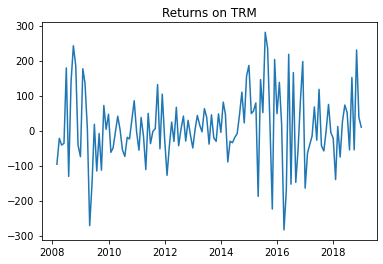

,PX_LAST
Dates,
2008-01-31,1939.60
2008-02-29,1843.59
2008-03-31,1821.60
2008-04-30,1780.21
2008-05-31,1744.01
...,...
2021-07-31,3867.88
2021-08-31,3806.87
2021-09-30,3834.68


In [131]:
returns=USDCOP_SAMPLE['PX_LAST'].diff().dropna()
returns = returns 
plt.plot(returns)
plt.title('Returns on TRM')
plt.show()


In [132]:
TestAdfuller=adfuller(returns)
print(TestAdfuller)

#El test confirma la estacionalidad de los datos


(-4.504012130678934, 0.00019338338066471127, 6, 124, {'1%': -3.484219653271961, '5%': -2.885145235641637, '10%': -2.579359138917794}, 1394.0399589529372)


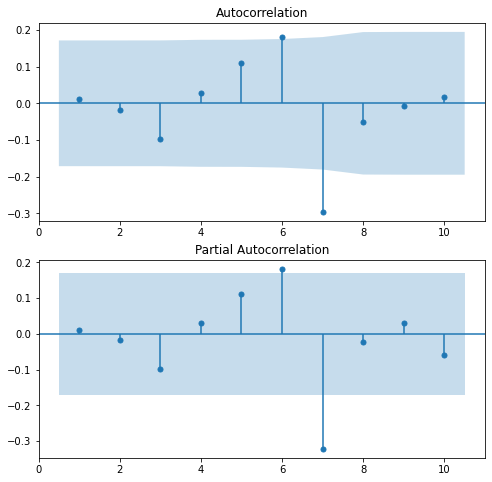

In [7]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(8,8))



plot_acf(returns,lags=10,zero=False,ax=ax1)
plot_pacf(returns,lags=10,zero=False,ax=ax2)
plt.show()

#los correlogramas muestran que los datos tienen lags y decaen, la parte autorregresiva de orden 1 
#y MA de orden 6

In [133]:
order_aic_bic =[]

for p in range(3):
 
    for q in range(3):

        model = SARIMAX(returns, order=(p,0,q))
        results = model.fit(disp=0)

        order_aic_bic.append((p, q, results.aic, results.bic))

order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

order_df=order_df.sort_values(by=['aic']).reset_index(drop=True)

order_df.head()


#Se realizan las pruebas AIC - BIC para encontrar los mejores modelos 

/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,q,aic,bic
0,0,0,1585.130669,1588.005867
1,2,2,1586.348477,1600.724463
2,0,1,1587.067067,1592.817461
3,1,0,1587.067785,1592.818180
4,2,0,1589.064964,1597.690556


In [134]:
#Rolling Window Function - January to September 2019 forecast

date_3 = dt.date(2008,1,31)
date_4=dt.date(2019,1,31)

Months_Window=9

Forecast_data = pd.DataFrame(columns = ['Initial_date','Final_date'])

for x in range (Months_Window):
    Forecast_data= Forecast_data.append({'Initial_date':date_3+ relativedelta(months=x) ,'Final_date' :date_4+ relativedelta(months=x)}, ignore_index = True)

print(Forecast_data)

  Initial_date  Final_date
0   2008-01-31  2019-01-31
1   2008-02-29  2019-02-28
2   2008-03-31  2019-03-31
3   2008-04-30  2019-04-30
4   2008-05-31  2019-05-31
5   2008-06-30  2019-06-30
6   2008-07-31  2019-07-31
7   2008-08-31  2019-08-31
8   2008-09-30  2019-09-30


In [559]:
Summary=pd.DataFrame(columns = ['Date','Real','Fcst1','Fcst2'])
Real_data=pd.DataFrame({'PX_LAST':[np.nan]*Months_Window})

for x in range(Months_Window):
  usdcop_Training=USDCOP.loc[Forecast_data.at[x,'Initial_date']:Forecast_data.at[x,'Final_date']+ relativedelta(months=x)]
  returns_training=usdcop_Training['PX_LAST'].dropna()
  Real_data.loc[x]=returns_training.iloc[-1]

Summary['Real']=Real_data['PX_LAST']

def get_Forecast_Rolling(Months_Window,p,q):
    Forecast_Rolling=pd.DataFrame({'Forecast' : [np.nan]*Months_Window})
    
    for x in range(Months_Window):
      usdcop_Training=USDCOP.loc[Forecast_data.at[x,'Initial_date']:Forecast_data.at[x,'Final_date']]
      returns_training=usdcop_Training['PX_LAST'].dropna()
      returns_training = returns_training 

      model_Roll=SARIMAX(returns_training, order=(p,0,q))
      results_Roll = model_Roll.fit(disp=0)
      forecast_Roll = results_Roll.get_prediction(start=1)
      mean_forecast_Roll=forecast_Roll.predicted_mean.to_frame('Prediction').reset_index()
      Forecast_Rolling.loc[x]=mean_forecast_Roll['Prediction'].iloc[-1]
    return Forecast_Rolling

#Segun los criterios AIC-BIC los dos mejores modelos son los siguientes:
Summary['Date']=Forecast_data['Final_date']
Summary['Fcst1']=get_Forecast_Rolling(Months_Window=Months_Window,p=1,q=2)['Forecast']
Summary['Fcst2']=get_Forecast_Rolling(Months_Window=Months_Window,p=0,q=2)['Forecast']
Summary.set_index('Date',inplace=True)
print(Summary)



/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


               Real        Fcst1        Fcst2
Date                                         
2019-01-31  3163.46  3247.295627  3304.349400
2019-02-28  3072.01  3158.617447  2154.043131
2019-03-31  3357.82  3069.528813  2266.366873
2019-04-30  3205.67  3175.585880  2216.144993
2019-05-31  3462.01  3246.736738  2439.706078
2019-06-30  3522.48  3356.705502  2755.605002
2019-07-31  3411.45  3196.753142  1871.675260
2019-08-31  4064.81  3301.948436  2995.476678
2019-09-30  3983.29  3420.225878  2444.582027


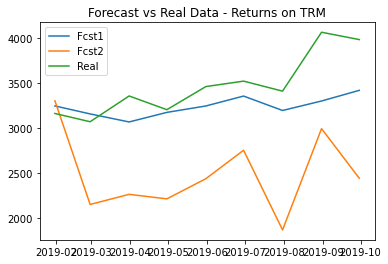

In [136]:
plt.plot(Summary['Fcst1'],label="Fcst1")
plt.plot(Summary['Fcst2'],label="Fcst2")
plt.plot(Summary['Real'],label="Real")
plt.title('Forecast vs Real Data - Returns on TRM')
plt.legend()

#Al revisar los pronósticos son mucho más acertados durante los primeros datos. 



In [494]:

#MODELO 1


def neuronal(x):
  return x


model_definition_MODEL1={
    "shapes":[tf.keras.Input(shape=(2,)),
              tf.keras.layers.Dense(7,activation=tf.nn.relu,),
              tf.keras.layers.Dense(8,activation=tf.nn.relu),
              tf.keras.layers.Dense(9,activation=tf.nn.relu),
              tf.keras.layers.Dense(10,activation=tf.nn.relu),
              tf.keras.layers.Dense(1,activation=neuronal)],
    "optimizer":tf.optimizers.Adam(learning_rate=0.001),
    "loss":tf.keras.losses.mean_squared_error,
    "metrics":["accuracy"]
}











In [493]:
#MODELO 2

model_definition_MODEL2={
    "shapes":[tf.keras.Input(shape=(2,)),
              tf.keras.layers.Dense(10,activation=tf.nn.relu,),
              tf.keras.layers.Dense(4,activation=tf.nn.relu),
            tf.keras.layers.Dense(9,activation=tf.nn.relu)],
    "optimizer":tf.optimizers.Adam(learning_rate=0.005),
    "loss":tf.keras.losses.mean_squared_error,
    "metrics":["accuracy"]
}







In [492]:
#MODELO 3

model_definition_MODEL3={
    "shapes":[tf.keras.Input(shape=(2,)),
                                    tf.keras.layers.Dense(5,activation=tf.nn.relu,),
                                    tf.keras.layers.Dense(2,activation=tf.nn.relu,),
                                    tf.keras.layers.Dense(1,activation=tf.nn.relu)],
    "optimizer":tf.optimizers.Adam(learning_rate=0.0005),
    "loss":tf.keras.losses.mean_squared_error,
    "metrics":["accuracy"]
}








In [495]:
months_window_dataframe= pd.DataFrame(columns=['StartDate','EndDate','StartPron','EndPron'])

month_window = 9

DATE_1 = dt.date(2010,1,31)
DATE_2=dt.date(2018,12,31)


for m in range(month_window):
    months_window_dataframe=months_window_dataframe.append({'StartDate':DATE_1+ relativedelta(months=m),
                                   'EndDate' :DATE_2+ relativedelta(months=m),
                                        'StartPron':DATE_2+ relativedelta(months=(m)),
                                        'EndPron':DATE_2 + relativedelta(months=(m+8))
                                        }, ignore_index = True)
months_window_dataframe

,StartDate,EndDate,StartPron,EndPron
0,2010-01-31,2018-12-31,2018-12-31,2019-08-31
1,2010-02-28,2019-01-31,2019-01-31,2019-09-30
2,2010-03-31,2019-02-28,2019-02-28,2019-10-31
3,2010-04-30,2019-03-31,2019-03-31,2019-11-30
4,2010-05-31,2019-04-30,2019-04-30,2019-12-31
5,2010-06-30,2019-05-31,2019-05-31,2020-01-31
6,2010-07-31,2019-06-30,2019-06-30,2020-02-29
7,2010-08-31,2019-07-31,2019-07-31,2020-03-31
8,2010-09-30,2019-08-31,2019-08-31,2020-04-30


In [496]:
def Predictors_Labels (Entr_data,Test_data):
    Tx=[]
    Ty=[]
    for index in range(len(Entr_data)):
        Tx.append([Entr_data.iloc[index,1],Entr_data.iloc[index,2]])
        Ty.append([Entr_data.iloc[index,0]])
        
    Testx=[]
    Testy=[]
    for i in range(len(Test_data)):
        Testx.append([Test_data.iloc[i,1],Test_data.iloc[i,2]])
        Testy.append([Test_data.iloc[i,0]]) 

    return Tx, Ty, Testx, Testy    
    

In [498]:
def Entr_Test (StartDate,EndDate,StartPron,EndPron,USDCOP):
    RN_entr=pd.DataFrame()
    RN_test=pd.DataFrame()
    
    Entr_data=USDCOP.loc[StartDate:EndDate]
    Test_data= USDCOP.loc[StartPron:EndPron]
    
    
    RN_entr['PX_LAST']=Entr_data['PX_LAST'].shift(0)
    RN_entr['PX_LAST1']=Entr_data['PX_LAST'].shift(1)
    RN_entr['PX_LAST2']=Entr_data['PX_LAST'].shift(2)
    RN_test['PX_LAST']=Test_data['PX_LAST'].shift(0)
    RN_test['PX_LAST1']=Test_data['PX_LAST'].shift(1)
    RN_test['PX_LAST2']=Test_data['PX_LAST'].shift(2)
    
 
    
    RN_entr=RN_entr.dropna()
    RN_test=RN_test.dropna()
    
    print(RN_test)
    
    return RN_entr,RN_test

In [540]:
N1=pd.DataFrame(columns = ['N1'])





for m in range(len(months_window_dataframe)):
    train, prove= Entr_Test(months_window_dataframe['StartDate'][m],months_window_dataframe['EndDate'][m],months_window_dataframe['StartPron'][m],months_window_dataframe['EndPron'][m], USDCOP)
    Tx_labels,Ty_labels, Testx_labels, Testy_labels=Predictors_Labels(train,prove)
    RN_MODEL1.fit(Tx_labels,Ty_labels,batch_size=30,epochs=400)
    MODEL_PREDICTS=RN_MODEL1.predict(Testx_labels)
    N1= N1.append({'N1':MODEL_PREDICTS[0,0]
                                          }, ignore_index = True)  
    



            PX_LAST  PX_LAST1  PX_LAST2
Dates                                  
2019-02-28  3072.01   3163.46   3249.75
2019-03-31  3174.79   3072.01   3163.46
2019-04-30  3247.72   3174.79   3072.01
2019-05-31  3357.82   3247.72   3174.79
2019-06-30  3205.67   3357.82   3247.72
2019-07-31  3296.85   3205.67   3357.82
2019-08-31  3427.29   3296.85   3205.67
Epoch 1/400
4/4 [==============================] - 0s 4ms/step - loss: 8253.0752 - accuracy: 0.0000e+00
Epoch 2/400
4/4 [==============================] - 0s 3ms/step - loss: 8653.4141 - accuracy: 0.0000e+00
Epoch 3/400
4/4 [==============================] - 0s 4ms/step - loss: 9031.1699 - accuracy: 0.0000e+00
Epoch 4/400
4/4 [==============================] - 0s 7ms/step - loss: 8435.1582 - accuracy: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 4ms/step - loss: 8280.5293 - accuracy: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 3ms/step - loss: 8216.9160 - accuracy: 0.0000e+00
Epoch 7/400
4/4 

4/4 [==============================] - 0s 5ms/step - loss: 8325.2900 - accuracy: 0.0000e+00
Epoch 76/400
4/4 [==============================] - 0s 7ms/step - loss: 8388.1748 - accuracy: 0.0000e+00
Epoch 77/400
4/4 [==============================] - 0s 3ms/step - loss: 8316.9590 - accuracy: 0.0000e+00
Epoch 78/400
4/4 [==============================] - 0s 4ms/step - loss: 8229.9785 - accuracy: 0.0000e+00
Epoch 79/400
4/4 [==============================] - 0s 3ms/step - loss: 8237.6670 - accuracy: 0.0000e+00
Epoch 80/400
4/4 [==============================] - 0s 5ms/step - loss: 8230.1777 - accuracy: 0.0000e+00
Epoch 81/400
4/4 [==============================] - 0s 4ms/step - loss: 8238.1914 - accuracy: 0.0000e+00
Epoch 82/400
4/4 [==============================] - 0s 3ms/step - loss: 8229.1895 - accuracy: 0.0000e+00
Epoch 83/400
4/4 [==============================] - 0s 3ms/step - loss: 8238.1865 - accuracy: 0.0000e+00
Epoch 84/400
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 5ms/step - loss: 8412.4326 - accuracy: 0.0000e+00
Epoch 153/400
4/4 [==============================] - 0s 5ms/step - loss: 8301.3164 - accuracy: 0.0000e+00
Epoch 154/400
4/4 [==============================] - 0s 4ms/step - loss: 8578.7500 - accuracy: 0.0000e+00
Epoch 155/400
4/4 [==============================] - 0s 4ms/step - loss: 8214.8877 - accuracy: 0.0000e+00
Epoch 156/400
4/4 [==============================] - 0s 3ms/step - loss: 8204.7080 - accuracy: 0.0000e+00
Epoch 157/400
4/4 [==============================] - 0s 3ms/step - loss: 8264.9990 - accuracy: 0.0000e+00
Epoch 158/400
4/4 [==============================] - 0s 3ms/step - loss: 8345.7812 - accuracy: 0.0000e+00
Epoch 159/400
4/4 [==============================] - 0s 3ms/step - loss: 8377.3613 - accuracy: 0.0000e+00
Epoch 160/400
4/4 [==============================] - 0s 3ms/step - loss: 8354.0820 - accuracy: 0.0000e+00
Epoch 161/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8580.7148 - accuracy: 0.0000e+00
Epoch 230/400
4/4 [==============================] - 0s 3ms/step - loss: 8382.3145 - accuracy: 0.0000e+00
Epoch 231/400
4/4 [==============================] - 0s 3ms/step - loss: 8291.4756 - accuracy: 0.0000e+00
Epoch 232/400
4/4 [==============================] - 0s 3ms/step - loss: 8265.4678 - accuracy: 0.0000e+00
Epoch 233/400
4/4 [==============================] - 0s 3ms/step - loss: 8413.5527 - accuracy: 0.0000e+00
Epoch 234/400
4/4 [==============================] - 0s 3ms/step - loss: 8295.7725 - accuracy: 0.0000e+00
Epoch 235/400
4/4 [==============================] - 0s 5ms/step - loss: 8256.5908 - accuracy: 0.0000e+00
Epoch 236/400
4/4 [==============================] - 0s 4ms/step - loss: 8279.7139 - accuracy: 0.0000e+00
Epoch 237/400
4/4 [==============================] - 0s 5ms/step - loss: 8661.6484 - accuracy: 0.0000e+00
Epoch 238/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8348.9648 - accuracy: 0.0000e+00
Epoch 307/400
4/4 [==============================] - 0s 3ms/step - loss: 8238.4561 - accuracy: 0.0000e+00
Epoch 308/400
4/4 [==============================] - 0s 3ms/step - loss: 8248.7998 - accuracy: 0.0000e+00
Epoch 309/400
4/4 [==============================] - 0s 3ms/step - loss: 8425.0859 - accuracy: 0.0000e+00
Epoch 310/400
4/4 [==============================] - 0s 3ms/step - loss: 8798.9199 - accuracy: 0.0000e+00
Epoch 311/400
4/4 [==============================] - 0s 3ms/step - loss: 8366.0137 - accuracy: 0.0000e+00
Epoch 312/400
4/4 [==============================] - 0s 3ms/step - loss: 8462.8955 - accuracy: 0.0000e+00
Epoch 313/400
4/4 [==============================] - 0s 4ms/step - loss: 8355.0215 - accuracy: 0.0000e+00
Epoch 314/400
4/4 [==============================] - 0s 3ms/step - loss: 8231.3311 - accuracy: 0.0000e+00
Epoch 315/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8270.2002 - accuracy: 0.0000e+00
Epoch 384/400
4/4 [==============================] - 0s 3ms/step - loss: 8312.8359 - accuracy: 0.0000e+00
Epoch 385/400
4/4 [==============================] - 0s 3ms/step - loss: 8646.4492 - accuracy: 0.0000e+00
Epoch 386/400
4/4 [==============================] - 0s 3ms/step - loss: 8289.8076 - accuracy: 0.0000e+00
Epoch 387/400
4/4 [==============================] - 0s 3ms/step - loss: 8324.9551 - accuracy: 0.0000e+00
Epoch 388/400
4/4 [==============================] - 0s 3ms/step - loss: 8196.4160 - accuracy: 0.0000e+00
Epoch 389/400
4/4 [==============================] - 0s 3ms/step - loss: 8276.1523 - accuracy: 0.0000e+00
Epoch 390/400
4/4 [==============================] - 0s 3ms/step - loss: 8347.7646 - accuracy: 0.0000e+00
Epoch 391/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.5137 - accuracy: 0.0000e+00
Epoch 392/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8468.1016 - accuracy: 0.0000e+00
Epoch 58/400
4/4 [==============================] - 0s 3ms/step - loss: 8531.4492 - accuracy: 0.0000e+00
Epoch 59/400
4/4 [==============================] - 0s 3ms/step - loss: 8308.4199 - accuracy: 0.0000e+00
Epoch 60/400
4/4 [==============================] - 0s 3ms/step - loss: 8480.3926 - accuracy: 0.0000e+00
Epoch 61/400
4/4 [==============================] - 0s 3ms/step - loss: 8597.2734 - accuracy: 0.0000e+00
Epoch 62/400
4/4 [==============================] - 0s 3ms/step - loss: 8471.7637 - accuracy: 0.0000e+00
Epoch 63/400
4/4 [==============================] - 0s 3ms/step - loss: 8365.4336 - accuracy: 0.0000e+00
Epoch 64/400
4/4 [==============================] - 0s 3ms/step - loss: 8466.7646 - accuracy: 0.0000e+00
Epoch 65/400
4/4 [==============================] - 0s 3ms/step - loss: 8680.3242 - accuracy: 0.0000e+00
Epoch 66/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 4ms/step - loss: 8576.8447 - accuracy: 0.0000e+00
Epoch 135/400
4/4 [==============================] - 0s 3ms/step - loss: 8333.8311 - accuracy: 0.0000e+00
Epoch 136/400
4/4 [==============================] - 0s 3ms/step - loss: 8374.1846 - accuracy: 0.0000e+00
Epoch 137/400
4/4 [==============================] - 0s 4ms/step - loss: 8323.2871 - accuracy: 0.0000e+00
Epoch 138/400
4/4 [==============================] - 0s 3ms/step - loss: 8329.4248 - accuracy: 0.0000e+00
Epoch 139/400
4/4 [==============================] - 0s 3ms/step - loss: 8392.5000 - accuracy: 0.0000e+00
Epoch 140/400
4/4 [==============================] - 0s 3ms/step - loss: 8360.7686 - accuracy: 0.0000e+00
Epoch 141/400
4/4 [==============================] - 0s 3ms/step - loss: 8365.0586 - accuracy: 0.0000e+00
Epoch 142/400
4/4 [==============================] - 0s 3ms/step - loss: 8702.8516 - accuracy: 0.0000e+00
Epoch 143/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8387.0264 - accuracy: 0.0000e+00
Epoch 212/400
4/4 [==============================] - 0s 3ms/step - loss: 8260.0264 - accuracy: 0.0000e+00
Epoch 213/400
4/4 [==============================] - 0s 3ms/step - loss: 8481.8496 - accuracy: 0.0000e+00
Epoch 214/400
4/4 [==============================] - 0s 3ms/step - loss: 8717.3623 - accuracy: 0.0000e+00
Epoch 215/400
4/4 [==============================] - 0s 3ms/step - loss: 8264.5664 - accuracy: 0.0000e+00
Epoch 216/400
4/4 [==============================] - 0s 3ms/step - loss: 8607.4590 - accuracy: 0.0000e+00
Epoch 217/400
4/4 [==============================] - 0s 3ms/step - loss: 8275.0996 - accuracy: 0.0000e+00
Epoch 218/400
4/4 [==============================] - 0s 3ms/step - loss: 8689.5107 - accuracy: 0.0000e+00
Epoch 219/400
4/4 [==============================] - 0s 3ms/step - loss: 8452.9131 - accuracy: 0.0000e+00
Epoch 220/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8372.7217 - accuracy: 0.0000e+00
Epoch 289/400
4/4 [==============================] - 0s 3ms/step - loss: 8245.9766 - accuracy: 0.0000e+00
Epoch 290/400
4/4 [==============================] - 0s 3ms/step - loss: 8290.7852 - accuracy: 0.0000e+00
Epoch 291/400
4/4 [==============================] - 0s 3ms/step - loss: 8333.9121 - accuracy: 0.0000e+00
Epoch 292/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.4697 - accuracy: 0.0000e+00
Epoch 293/400
4/4 [==============================] - 0s 3ms/step - loss: 8274.9824 - accuracy: 0.0000e+00
Epoch 294/400
4/4 [==============================] - 0s 3ms/step - loss: 8405.1455 - accuracy: 0.0000e+00
Epoch 295/400
4/4 [==============================] - 0s 3ms/step - loss: 8303.3906 - accuracy: 0.0000e+00
Epoch 296/400
4/4 [==============================] - 0s 3ms/step - loss: 8457.7012 - accuracy: 0.0000e+00
Epoch 297/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8314.5938 - accuracy: 0.0000e+00
Epoch 366/400
4/4 [==============================] - 0s 3ms/step - loss: 8346.2178 - accuracy: 0.0000e+00
Epoch 367/400
4/4 [==============================] - 0s 3ms/step - loss: 8354.4844 - accuracy: 0.0000e+00
Epoch 368/400
4/4 [==============================] - 0s 3ms/step - loss: 8285.3477 - accuracy: 0.0000e+00
Epoch 369/400
4/4 [==============================] - 0s 3ms/step - loss: 8213.6855 - accuracy: 0.0000e+00
Epoch 370/400
4/4 [==============================] - 0s 3ms/step - loss: 8498.5693 - accuracy: 0.0000e+00
Epoch 371/400
4/4 [==============================] - 0s 3ms/step - loss: 8408.1875 - accuracy: 0.0000e+00
Epoch 372/400
4/4 [==============================] - 0s 3ms/step - loss: 8442.0352 - accuracy: 0.0000e+00
Epoch 373/400
4/4 [==============================] - 0s 4ms/step - loss: 8343.9121 - accuracy: 0.0000e+00
Epoch 374/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8452.0303 - accuracy: 0.0000e+00
Epoch 40/400
4/4 [==============================] - 0s 3ms/step - loss: 8612.3076 - accuracy: 0.0000e+00
Epoch 41/400
4/4 [==============================] - 0s 3ms/step - loss: 8481.9727 - accuracy: 0.0000e+00
Epoch 42/400
4/4 [==============================] - 0s 3ms/step - loss: 8528.6465 - accuracy: 0.0000e+00
Epoch 43/400
4/4 [==============================] - 0s 4ms/step - loss: 8583.1387 - accuracy: 0.0000e+00
Epoch 44/400
4/4 [==============================] - 0s 3ms/step - loss: 8863.3398 - accuracy: 0.0000e+00
Epoch 45/400
4/4 [==============================] - 0s 3ms/step - loss: 8411.0010 - accuracy: 0.0000e+00
Epoch 46/400
4/4 [==============================] - 0s 3ms/step - loss: 8452.4072 - accuracy: 0.0000e+00
Epoch 47/400
4/4 [==============================] - 0s 3ms/step - loss: 8418.0273 - accuracy: 0.0000e+00
Epoch 48/400
4/4 [==============================] - 0s 3ms/step - lo

Epoch 117/400
4/4 [==============================] - 0s 3ms/step - loss: 8446.7441 - accuracy: 0.0000e+00
Epoch 118/400
4/4 [==============================] - 0s 3ms/step - loss: 8442.5586 - accuracy: 0.0000e+00
Epoch 119/400
4/4 [==============================] - 0s 3ms/step - loss: 8329.1807 - accuracy: 0.0000e+00
Epoch 120/400
4/4 [==============================] - 0s 3ms/step - loss: 8471.9014 - accuracy: 0.0000e+00
Epoch 121/400
4/4 [==============================] - 0s 4ms/step - loss: 8731.4014 - accuracy: 0.0000e+00
Epoch 122/400
4/4 [==============================] - 0s 3ms/step - loss: 8393.7012 - accuracy: 0.0000e+00
Epoch 123/400
4/4 [==============================] - 0s 3ms/step - loss: 8837.7959 - accuracy: 0.0000e+00
Epoch 124/400
4/4 [==============================] - 0s 3ms/step - loss: 8541.9902 - accuracy: 0.0000e+00
Epoch 125/400
4/4 [==============================] - 0s 3ms/step - loss: 8619.4570 - accuracy: 0.0000e+00
Epoch 126/400
4/4 [===========================

4/4 [==============================] - 0s 3ms/step - loss: 8502.6963 - accuracy: 0.0000e+00
Epoch 195/400
4/4 [==============================] - 0s 3ms/step - loss: 8469.2881 - accuracy: 0.0000e+00
Epoch 196/400
4/4 [==============================] - 0s 3ms/step - loss: 8511.6465 - accuracy: 0.0000e+00
Epoch 197/400
4/4 [==============================] - 0s 3ms/step - loss: 8418.8389 - accuracy: 0.0000e+00
Epoch 198/400
4/4 [==============================] - 0s 3ms/step - loss: 8407.8174 - accuracy: 0.0000e+00
Epoch 199/400
4/4 [==============================] - 0s 3ms/step - loss: 8444.7832 - accuracy: 0.0000e+00
Epoch 200/400
4/4 [==============================] - 0s 3ms/step - loss: 8503.6553 - accuracy: 0.0000e+00
Epoch 201/400
4/4 [==============================] - 0s 3ms/step - loss: 8600.9756 - accuracy: 0.0000e+00
Epoch 202/400
4/4 [==============================] - 0s 3ms/step - loss: 8633.4785 - accuracy: 0.0000e+00
Epoch 203/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8456.0830 - accuracy: 0.0000e+00
Epoch 272/400
4/4 [==============================] - 0s 3ms/step - loss: 8553.0186 - accuracy: 0.0000e+00
Epoch 273/400
4/4 [==============================] - 0s 3ms/step - loss: 8401.6074 - accuracy: 0.0000e+00
Epoch 274/400
4/4 [==============================] - 0s 3ms/step - loss: 8501.4160 - accuracy: 0.0000e+00
Epoch 275/400
4/4 [==============================] - 0s 3ms/step - loss: 8479.9668 - accuracy: 0.0000e+00
Epoch 276/400
4/4 [==============================] - 0s 3ms/step - loss: 8438.6406 - accuracy: 0.0000e+00
Epoch 277/400
4/4 [==============================] - 0s 3ms/step - loss: 8508.0264 - accuracy: 0.0000e+00
Epoch 278/400
4/4 [==============================] - 0s 3ms/step - loss: 8394.8525 - accuracy: 0.0000e+00
Epoch 279/400
4/4 [==============================] - 0s 3ms/step - loss: 8445.1719 - accuracy: 0.0000e+00
Epoch 280/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8409.8564 - accuracy: 0.0000e+00
Epoch 349/400
4/4 [==============================] - 0s 3ms/step - loss: 8435.9600 - accuracy: 0.0000e+00
Epoch 350/400
4/4 [==============================] - 0s 3ms/step - loss: 8564.2812 - accuracy: 0.0000e+00
Epoch 351/400
4/4 [==============================] - 0s 3ms/step - loss: 8379.3418 - accuracy: 0.0000e+00
Epoch 352/400
4/4 [==============================] - 0s 3ms/step - loss: 8417.4941 - accuracy: 0.0000e+00
Epoch 353/400
4/4 [==============================] - 0s 3ms/step - loss: 8554.5684 - accuracy: 0.0000e+00
Epoch 354/400
4/4 [==============================] - 0s 3ms/step - loss: 8562.2480 - accuracy: 0.0000e+00
Epoch 355/400
4/4 [==============================] - 0s 3ms/step - loss: 8457.2666 - accuracy: 0.0000e+00
Epoch 356/400
4/4 [==============================] - 0s 3ms/step - loss: 8398.8955 - accuracy: 0.0000e+00
Epoch 357/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8451.3457 - accuracy: 0.0000e+00
Epoch 23/400
4/4 [==============================] - 0s 3ms/step - loss: 8558.3291 - accuracy: 0.0000e+00
Epoch 24/400
4/4 [==============================] - 0s 3ms/step - loss: 8514.5547 - accuracy: 0.0000e+00
Epoch 25/400
4/4 [==============================] - 0s 3ms/step - loss: 8477.1523 - accuracy: 0.0000e+00
Epoch 26/400
4/4 [==============================] - 0s 3ms/step - loss: 8404.7930 - accuracy: 0.0000e+00
Epoch 27/400
4/4 [==============================] - 0s 4ms/step - loss: 8579.2891 - accuracy: 0.0000e+00
Epoch 28/400
4/4 [==============================] - 0s 3ms/step - loss: 8498.8545 - accuracy: 0.0000e+00
Epoch 29/400
4/4 [==============================] - 0s 3ms/step - loss: 8618.1475 - accuracy: 0.0000e+00
Epoch 30/400
4/4 [==============================] - 0s 3ms/step - loss: 8457.2783 - accuracy: 0.0000e+00
Epoch 31/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8452.1348 - accuracy: 0.0000e+00
Epoch 101/400
4/4 [==============================] - 0s 3ms/step - loss: 8404.5527 - accuracy: 0.0000e+00
Epoch 102/400
4/4 [==============================] - 0s 3ms/step - loss: 8493.9053 - accuracy: 0.0000e+00
Epoch 103/400
4/4 [==============================] - 0s 3ms/step - loss: 8431.0752 - accuracy: 0.0000e+00
Epoch 104/400
4/4 [==============================] - 0s 3ms/step - loss: 8551.7197 - accuracy: 0.0000e+00
Epoch 105/400
4/4 [==============================] - 0s 3ms/step - loss: 8661.9561 - accuracy: 0.0000e+00
Epoch 106/400
4/4 [==============================] - 0s 3ms/step - loss: 8467.9766 - accuracy: 0.0000e+00
Epoch 107/400
4/4 [==============================] - 0s 3ms/step - loss: 8534.7344 - accuracy: 0.0000e+00
Epoch 108/400
4/4 [==============================] - 0s 3ms/step - loss: 8625.2002 - accuracy: 0.0000e+00
Epoch 109/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8587.6621 - accuracy: 0.0000e+00
Epoch 178/400
4/4 [==============================] - 0s 3ms/step - loss: 8462.6982 - accuracy: 0.0000e+00
Epoch 179/400
4/4 [==============================] - 0s 4ms/step - loss: 8426.7764 - accuracy: 0.0000e+00
Epoch 180/400
4/4 [==============================] - 0s 3ms/step - loss: 8445.6631 - accuracy: 0.0000e+00
Epoch 181/400
4/4 [==============================] - 0s 3ms/step - loss: 8512.1943 - accuracy: 0.0000e+00
Epoch 182/400
4/4 [==============================] - 0s 3ms/step - loss: 8504.7197 - accuracy: 0.0000e+00
Epoch 183/400
4/4 [==============================] - 0s 3ms/step - loss: 8459.4941 - accuracy: 0.0000e+00
Epoch 184/400
4/4 [==============================] - 0s 3ms/step - loss: 8428.4883 - accuracy: 0.0000e+00
Epoch 185/400
4/4 [==============================] - 0s 3ms/step - loss: 8598.1143 - accuracy: 0.0000e+00
Epoch 186/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8554.1367 - accuracy: 0.0000e+00
Epoch 255/400
4/4 [==============================] - 0s 3ms/step - loss: 8833.1855 - accuracy: 0.0000e+00
Epoch 256/400
4/4 [==============================] - 0s 3ms/step - loss: 8543.4189 - accuracy: 0.0000e+00
Epoch 257/400
4/4 [==============================] - 0s 3ms/step - loss: 8435.1123 - accuracy: 0.0000e+00
Epoch 258/400
4/4 [==============================] - 0s 3ms/step - loss: 8563.8574 - accuracy: 0.0000e+00
Epoch 259/400
4/4 [==============================] - 0s 3ms/step - loss: 8407.9219 - accuracy: 0.0000e+00
Epoch 260/400
4/4 [==============================] - 0s 3ms/step - loss: 8778.5068 - accuracy: 0.0000e+00
Epoch 261/400
4/4 [==============================] - 0s 3ms/step - loss: 8425.0771 - accuracy: 0.0000e+00
Epoch 262/400
4/4 [==============================] - 0s 3ms/step - loss: 8501.9766 - accuracy: 0.0000e+00
Epoch 263/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8425.0244 - accuracy: 0.0000e+00
Epoch 332/400
4/4 [==============================] - 0s 3ms/step - loss: 8587.5117 - accuracy: 0.0000e+00
Epoch 333/400
4/4 [==============================] - 0s 3ms/step - loss: 8527.4590 - accuracy: 0.0000e+00
Epoch 334/400
4/4 [==============================] - 0s 3ms/step - loss: 8442.6318 - accuracy: 0.0000e+00
Epoch 335/400
4/4 [==============================] - 0s 3ms/step - loss: 8502.3311 - accuracy: 0.0000e+00
Epoch 336/400
4/4 [==============================] - 0s 3ms/step - loss: 8473.1865 - accuracy: 0.0000e+00
Epoch 337/400
4/4 [==============================] - 0s 3ms/step - loss: 8569.2891 - accuracy: 0.0000e+00
Epoch 338/400
4/4 [==============================] - 0s 3ms/step - loss: 8489.1436 - accuracy: 0.0000e+00
Epoch 339/400
4/4 [==============================] - 0s 3ms/step - loss: 8521.7402 - accuracy: 0.0000e+00
Epoch 340/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8526.9795 - accuracy: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 3ms/step - loss: 8628.5186 - accuracy: 0.0000e+00
Epoch 7/400
4/4 [==============================] - 0s 3ms/step - loss: 8732.4844 - accuracy: 0.0000e+00
Epoch 8/400
4/4 [==============================] - 0s 3ms/step - loss: 8471.5547 - accuracy: 0.0000e+00
Epoch 9/400
4/4 [==============================] - 0s 4ms/step - loss: 8531.8750 - accuracy: 0.0000e+00
Epoch 10/400
4/4 [==============================] - 0s 3ms/step - loss: 8494.8525 - accuracy: 0.0000e+00
Epoch 11/400
4/4 [==============================] - 0s 4ms/step - loss: 8475.7842 - accuracy: 0.0000e+00
Epoch 12/400
4/4 [==============================] - 0s 4ms/step - loss: 8443.7988 - accuracy: 0.0000e+00
Epoch 13/400
4/4 [==============================] - 0s 3ms/step - loss: 8494.4707 - accuracy: 0.0000e+00
Epoch 14/400
4/4 [==============================] - 0s 3ms/step - loss: 

4/4 [==============================] - 0s 3ms/step - loss: 8435.4766 - accuracy: 0.0000e+00
Epoch 84/400
4/4 [==============================] - 0s 3ms/step - loss: 8885.1670 - accuracy: 0.0000e+00
Epoch 85/400
4/4 [==============================] - 0s 4ms/step - loss: 9102.7021 - accuracy: 0.0000e+00
Epoch 86/400
4/4 [==============================] - 0s 3ms/step - loss: 9042.2041 - accuracy: 0.0000e+00
Epoch 87/400
4/4 [==============================] - 0s 4ms/step - loss: 8767.5127 - accuracy: 0.0000e+00
Epoch 88/400
4/4 [==============================] - 0s 3ms/step - loss: 8637.8594 - accuracy: 0.0000e+00
Epoch 89/400
4/4 [==============================] - 0s 3ms/step - loss: 8547.9141 - accuracy: 0.0000e+00
Epoch 90/400
4/4 [==============================] - 0s 3ms/step - loss: 9029.1123 - accuracy: 0.0000e+00
Epoch 91/400
4/4 [==============================] - 0s 3ms/step - loss: 8625.1494 - accuracy: 0.0000e+00
Epoch 92/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8638.8486 - accuracy: 0.0000e+00
Epoch 161/400
4/4 [==============================] - 0s 3ms/step - loss: 8558.0176 - accuracy: 0.0000e+00
Epoch 162/400
4/4 [==============================] - 0s 4ms/step - loss: 8623.3740 - accuracy: 0.0000e+00
Epoch 163/400
4/4 [==============================] - 0s 3ms/step - loss: 8715.4932 - accuracy: 0.0000e+00
Epoch 164/400
4/4 [==============================] - 0s 3ms/step - loss: 8627.8252 - accuracy: 0.0000e+00
Epoch 165/400
4/4 [==============================] - 0s 3ms/step - loss: 8456.7510 - accuracy: 0.0000e+00
Epoch 166/400
4/4 [==============================] - 0s 4ms/step - loss: 8572.2568 - accuracy: 0.0000e+00
Epoch 167/400
4/4 [==============================] - 0s 3ms/step - loss: 8607.9707 - accuracy: 0.0000e+00
Epoch 168/400
4/4 [==============================] - 0s 3ms/step - loss: 8606.0020 - accuracy: 0.0000e+00
Epoch 169/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8685.9814 - accuracy: 0.0000e+00
Epoch 238/400
4/4 [==============================] - 0s 3ms/step - loss: 8653.9102 - accuracy: 0.0000e+00
Epoch 239/400
4/4 [==============================] - 0s 3ms/step - loss: 8705.2295 - accuracy: 0.0000e+00
Epoch 240/400
4/4 [==============================] - 0s 4ms/step - loss: 8497.7676 - accuracy: 0.0000e+00
Epoch 241/400
4/4 [==============================] - 0s 3ms/step - loss: 8477.8184 - accuracy: 0.0000e+00
Epoch 242/400
4/4 [==============================] - 0s 3ms/step - loss: 8520.1016 - accuracy: 0.0000e+00
Epoch 243/400
4/4 [==============================] - 0s 3ms/step - loss: 8519.7607 - accuracy: 0.0000e+00
Epoch 244/400
4/4 [==============================] - 0s 3ms/step - loss: 8526.3994 - accuracy: 0.0000e+00
Epoch 245/400
4/4 [==============================] - 0s 3ms/step - loss: 8538.0068 - accuracy: 0.0000e+00
Epoch 246/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8401.2236 - accuracy: 0.0000e+00
Epoch 315/400
4/4 [==============================] - 0s 3ms/step - loss: 8818.4424 - accuracy: 0.0000e+00
Epoch 316/400
4/4 [==============================] - 0s 3ms/step - loss: 8850.2451 - accuracy: 0.0000e+00
Epoch 317/400
4/4 [==============================] - 0s 3ms/step - loss: 8825.1895 - accuracy: 0.0000e+00
Epoch 318/400
4/4 [==============================] - 0s 3ms/step - loss: 8655.9561 - accuracy: 0.0000e+00
Epoch 319/400
4/4 [==============================] - 0s 3ms/step - loss: 8554.9531 - accuracy: 0.0000e+00
Epoch 320/400
4/4 [==============================] - 0s 3ms/step - loss: 8644.0576 - accuracy: 0.0000e+00
Epoch 321/400
4/4 [==============================] - 0s 3ms/step - loss: 8559.3398 - accuracy: 0.0000e+00
Epoch 322/400
4/4 [==============================] - 0s 3ms/step - loss: 8520.6123 - accuracy: 0.0000e+00
Epoch 323/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 5ms/step - loss: 8767.6006 - accuracy: 0.0000e+00
Epoch 392/400
4/4 [==============================] - 0s 3ms/step - loss: 8697.7510 - accuracy: 0.0000e+00
Epoch 393/400
4/4 [==============================] - 0s 3ms/step - loss: 8545.2607 - accuracy: 0.0000e+00
Epoch 394/400
4/4 [==============================] - 0s 4ms/step - loss: 8478.2607 - accuracy: 0.0000e+00
Epoch 395/400
4/4 [==============================] - 0s 3ms/step - loss: 8690.5166 - accuracy: 0.0000e+00
Epoch 396/400
4/4 [==============================] - 0s 7ms/step - loss: 8678.6240 - accuracy: 0.0000e+00
Epoch 397/400
4/4 [==============================] - 0s 3ms/step - loss: 8498.5732 - accuracy: 0.0000e+00
Epoch 398/400
4/4 [==============================] - 0s 3ms/step - loss: 8481.0557 - accuracy: 0.0000e+00
Epoch 399/400
4/4 [==============================] - 0s 3ms/step - loss: 8577.9590 - accuracy: 0.0000e+00
Epoch 400/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8523.3564 - accuracy: 0.0000e+00
Epoch 66/400
4/4 [==============================] - 0s 3ms/step - loss: 8774.4707 - accuracy: 0.0000e+00
Epoch 67/400
4/4 [==============================] - 0s 3ms/step - loss: 9102.4893 - accuracy: 0.0000e+00
Epoch 68/400
4/4 [==============================] - 0s 3ms/step - loss: 9156.8691 - accuracy: 0.0000e+00
Epoch 69/400
4/4 [==============================] - 0s 4ms/step - loss: 8770.6689 - accuracy: 0.0000e+00
Epoch 70/400
4/4 [==============================] - 0s 3ms/step - loss: 8445.1387 - accuracy: 0.0000e+00
Epoch 71/400
4/4 [==============================] - 0s 3ms/step - loss: 8851.3369 - accuracy: 0.0000e+00
Epoch 72/400
4/4 [==============================] - 0s 4ms/step - loss: 8681.2637 - accuracy: 0.0000e+00
Epoch 73/400
4/4 [==============================] - 0s 3ms/step - loss: 8971.5654 - accuracy: 0.0000e+00
Epoch 74/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 4ms/step - loss: 8696.2637 - accuracy: 0.0000e+00
Epoch 143/400
4/4 [==============================] - 0s 3ms/step - loss: 8603.1162 - accuracy: 0.0000e+00
Epoch 144/400
4/4 [==============================] - 0s 3ms/step - loss: 8584.2656 - accuracy: 0.0000e+00
Epoch 145/400
4/4 [==============================] - 0s 3ms/step - loss: 8485.0684 - accuracy: 0.0000e+00
Epoch 146/400
4/4 [==============================] - 0s 3ms/step - loss: 8464.7109 - accuracy: 0.0000e+00
Epoch 147/400
4/4 [==============================] - 0s 3ms/step - loss: 8472.8701 - accuracy: 0.0000e+00
Epoch 148/400
4/4 [==============================] - 0s 4ms/step - loss: 8583.9746 - accuracy: 0.0000e+00
Epoch 149/400
4/4 [==============================] - 0s 3ms/step - loss: 8523.8398 - accuracy: 0.0000e+00
Epoch 150/400
4/4 [==============================] - 0s 3ms/step - loss: 8577.2207 - accuracy: 0.0000e+00
Epoch 151/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8529.4531 - accuracy: 0.0000e+00
Epoch 219/400
4/4 [==============================] - 0s 3ms/step - loss: 8528.9268 - accuracy: 0.0000e+00
Epoch 220/400
4/4 [==============================] - 0s 3ms/step - loss: 8482.6084 - accuracy: 0.0000e+00
Epoch 221/400
4/4 [==============================] - 0s 3ms/step - loss: 8646.5566 - accuracy: 0.0000e+00
Epoch 222/400
4/4 [==============================] - 0s 3ms/step - loss: 8604.9209 - accuracy: 0.0000e+00
Epoch 223/400
4/4 [==============================] - 0s 3ms/step - loss: 8832.1650 - accuracy: 0.0000e+00
Epoch 224/400
4/4 [==============================] - 0s 3ms/step - loss: 8687.0557 - accuracy: 0.0000e+00
Epoch 225/400
4/4 [==============================] - 0s 3ms/step - loss: 8956.9756 - accuracy: 0.0000e+00
Epoch 226/400
4/4 [==============================] - 0s 4ms/step - loss: 8527.1826 - accuracy: 0.0000e+00
Epoch 227/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8603.0381 - accuracy: 0.0000e+00
Epoch 296/400
4/4 [==============================] - 0s 4ms/step - loss: 8685.9355 - accuracy: 0.0000e+00
Epoch 297/400
4/4 [==============================] - 0s 3ms/step - loss: 8593.7822 - accuracy: 0.0000e+00
Epoch 298/400
4/4 [==============================] - 0s 3ms/step - loss: 8532.6865 - accuracy: 0.0000e+00
Epoch 299/400
4/4 [==============================] - 0s 3ms/step - loss: 8671.1836 - accuracy: 0.0000e+00
Epoch 300/400
4/4 [==============================] - 0s 4ms/step - loss: 8566.2119 - accuracy: 0.0000e+00
Epoch 301/400
4/4 [==============================] - 0s 8ms/step - loss: 8758.5576 - accuracy: 0.0000e+00
Epoch 302/400
4/4 [==============================] - 0s 8ms/step - loss: 9105.7334 - accuracy: 0.0000e+00
Epoch 303/400
4/4 [==============================] - 0s 6ms/step - loss: 8726.1221 - accuracy: 0.0000e+00
Epoch 304/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8635.0459 - accuracy: 0.0000e+00
Epoch 373/400
4/4 [==============================] - 0s 3ms/step - loss: 8585.8477 - accuracy: 0.0000e+00
Epoch 374/400
4/4 [==============================] - 0s 3ms/step - loss: 8567.9258 - accuracy: 0.0000e+00
Epoch 375/400
4/4 [==============================] - 0s 4ms/step - loss: 8543.9043 - accuracy: 0.0000e+00
Epoch 376/400
4/4 [==============================] - 0s 3ms/step - loss: 8684.5010 - accuracy: 0.0000e+00
Epoch 377/400
4/4 [==============================] - 0s 3ms/step - loss: 8543.5947 - accuracy: 0.0000e+00
Epoch 378/400
4/4 [==============================] - 0s 5ms/step - loss: 8668.0518 - accuracy: 0.0000e+00
Epoch 379/400
4/4 [==============================] - 0s 5ms/step - loss: 8831.0283 - accuracy: 0.0000e+00
Epoch 380/400
4/4 [==============================] - 0s 6ms/step - loss: 8542.6797 - accuracy: 0.0000e+00
Epoch 381/400
4/4 [==============================] - 0s 6ms/

4/4 [==============================] - 0s 3ms/step - loss: 9415.0391 - accuracy: 0.0000e+00
Epoch 47/400
4/4 [==============================] - 0s 3ms/step - loss: 8922.3428 - accuracy: 0.0000e+00
Epoch 48/400
4/4 [==============================] - 0s 3ms/step - loss: 8828.1240 - accuracy: 0.0000e+00
Epoch 49/400
4/4 [==============================] - 0s 3ms/step - loss: 8765.6592 - accuracy: 0.0000e+00
Epoch 50/400
4/4 [==============================] - 0s 3ms/step - loss: 8772.3672 - accuracy: 0.0000e+00
Epoch 51/400
4/4 [==============================] - 0s 3ms/step - loss: 8925.7920 - accuracy: 0.0000e+00
Epoch 52/400
4/4 [==============================] - 0s 3ms/step - loss: 8545.1816 - accuracy: 0.0000e+00
Epoch 53/400
4/4 [==============================] - 0s 3ms/step - loss: 8817.3281 - accuracy: 0.0000e+00
Epoch 54/400
4/4 [==============================] - 0s 4ms/step - loss: 8743.6348 - accuracy: 0.0000e+00
Epoch 55/400
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8788.3486 - accuracy: 0.0000e+00
Epoch 124/400
4/4 [==============================] - 0s 3ms/step - loss: 8701.6641 - accuracy: 0.0000e+00
Epoch 125/400
4/4 [==============================] - 0s 4ms/step - loss: 8704.2988 - accuracy: 0.0000e+00
Epoch 126/400
4/4 [==============================] - 0s 3ms/step - loss: 8799.9707 - accuracy: 0.0000e+00
Epoch 127/400
4/4 [==============================] - 0s 3ms/step - loss: 8720.0332 - accuracy: 0.0000e+00
Epoch 128/400
4/4 [==============================] - 0s 3ms/step - loss: 8666.9072 - accuracy: 0.0000e+00
Epoch 129/400
4/4 [==============================] - 0s 4ms/step - loss: 8775.1113 - accuracy: 0.0000e+00
Epoch 130/400
4/4 [==============================] - 0s 3ms/step - loss: 8704.0264 - accuracy: 0.0000e+00
Epoch 131/400
4/4 [==============================] - 0s 4ms/step - loss: 8742.7598 - accuracy: 0.0000e+00
Epoch 132/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8695.5312 - accuracy: 0.0000e+00
Epoch 201/400
4/4 [==============================] - 0s 3ms/step - loss: 8750.2734 - accuracy: 0.0000e+00
Epoch 202/400
4/4 [==============================] - 0s 3ms/step - loss: 8792.1953 - accuracy: 0.0000e+00
Epoch 203/400
4/4 [==============================] - 0s 4ms/step - loss: 8684.3359 - accuracy: 0.0000e+00
Epoch 204/400
4/4 [==============================] - 0s 4ms/step - loss: 8788.8457 - accuracy: 0.0000e+00
Epoch 205/400
4/4 [==============================] - 0s 4ms/step - loss: 8706.5918 - accuracy: 0.0000e+00
Epoch 206/400
4/4 [==============================] - 0s 3ms/step - loss: 8613.9014 - accuracy: 0.0000e+00
Epoch 207/400
4/4 [==============================] - 0s 3ms/step - loss: 8668.8750 - accuracy: 0.0000e+00
Epoch 208/400
4/4 [==============================] - 0s 4ms/step - loss: 8606.7803 - accuracy: 0.0000e+00
Epoch 209/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8865.6670 - accuracy: 0.0000e+00
Epoch 278/400
4/4 [==============================] - 0s 3ms/step - loss: 9070.9766 - accuracy: 0.0000e+00
Epoch 279/400
4/4 [==============================] - 0s 10ms/step - loss: 8721.4473 - accuracy: 0.0000e+00
Epoch 280/400
4/4 [==============================] - 0s 7ms/step - loss: 8674.7822 - accuracy: 0.0000e+00
Epoch 281/400
4/4 [==============================] - 0s 8ms/step - loss: 8777.9805 - accuracy: 0.0000e+00
Epoch 282/400
4/4 [==============================] - 0s 6ms/step - loss: 8630.1426 - accuracy: 0.0000e+00
Epoch 283/400
4/4 [==============================] - 0s 3ms/step - loss: 8679.9785 - accuracy: 0.0000e+00
Epoch 284/400
4/4 [==============================] - 0s 3ms/step - loss: 8726.1768 - accuracy: 0.0000e+00
Epoch 285/400
4/4 [==============================] - 0s 3ms/step - loss: 8673.9092 - accuracy: 0.0000e+00
Epoch 286/400
4/4 [==============================] - 0s 5ms

4/4 [==============================] - 0s 3ms/step - loss: 8917.7607 - accuracy: 0.0000e+00
Epoch 355/400
4/4 [==============================] - 0s 3ms/step - loss: 8836.6201 - accuracy: 0.0000e+00
Epoch 356/400
4/4 [==============================] - 0s 3ms/step - loss: 8701.0840 - accuracy: 0.0000e+00
Epoch 357/400
4/4 [==============================] - 0s 3ms/step - loss: 8673.8486 - accuracy: 0.0000e+00
Epoch 358/400
4/4 [==============================] - 0s 3ms/step - loss: 8813.7402 - accuracy: 0.0000e+00
Epoch 359/400
4/4 [==============================] - 0s 3ms/step - loss: 8924.1709 - accuracy: 0.0000e+00
Epoch 360/400
4/4 [==============================] - 0s 3ms/step - loss: 8685.2031 - accuracy: 0.0000e+00
Epoch 361/400
4/4 [==============================] - 0s 3ms/step - loss: 8762.9795 - accuracy: 0.0000e+00
Epoch 362/400
4/4 [==============================] - 0s 3ms/step - loss: 8828.7266 - accuracy: 0.0000e+00
Epoch 363/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8830.2051 - accuracy: 0.0000e+00
Epoch 29/400
4/4 [==============================] - 0s 4ms/step - loss: 8793.6406 - accuracy: 0.0000e+00
Epoch 30/400
4/4 [==============================] - 0s 4ms/step - loss: 8697.7295 - accuracy: 0.0000e+00
Epoch 31/400
4/4 [==============================] - 0s 4ms/step - loss: 8903.9727 - accuracy: 0.0000e+00
Epoch 32/400
4/4 [==============================] - 0s 3ms/step - loss: 8783.0166 - accuracy: 0.0000e+00
Epoch 33/400
4/4 [==============================] - 0s 3ms/step - loss: 8669.1123 - accuracy: 0.0000e+00
Epoch 34/400
4/4 [==============================] - 0s 3ms/step - loss: 8914.3252 - accuracy: 0.0000e+00
Epoch 35/400
4/4 [==============================] - 0s 4ms/step - loss: 8833.3818 - accuracy: 0.0000e+00
Epoch 36/400
4/4 [==============================] - 0s 3ms/step - loss: 8713.1143 - accuracy: 0.0000e+00
Epoch 37/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 9118.5293 - accuracy: 0.0000e+00
Epoch 107/400
4/4 [==============================] - 0s 8ms/step - loss: 8870.8701 - accuracy: 0.0000e+00
Epoch 108/400
4/4 [==============================] - 0s 3ms/step - loss: 8926.0840 - accuracy: 0.0000e+00
Epoch 109/400
4/4 [==============================] - 0s 3ms/step - loss: 8722.6826 - accuracy: 0.0000e+00
Epoch 110/400
4/4 [==============================] - 0s 3ms/step - loss: 8738.4414 - accuracy: 0.0000e+00
Epoch 111/400
4/4 [==============================] - 0s 4ms/step - loss: 8701.2852 - accuracy: 0.0000e+00
Epoch 112/400
4/4 [==============================] - 0s 3ms/step - loss: 8615.0078 - accuracy: 0.0000e+00
Epoch 113/400
4/4 [==============================] - ETA: 0s - loss: 7730.3818 - accuracy: 0.0000e+0 - 0s 5ms/step - loss: 8647.5293 - accuracy: 0.0000e+00
Epoch 114/400
4/4 [==============================] - 0s 7ms/step - loss: 8706.1670 - accuracy: 0.0000e+00
Epoch 115/

4/4 [==============================] - 0s 4ms/step - loss: 8837.9629 - accuracy: 0.0000e+00
Epoch 183/400
4/4 [==============================] - 0s 3ms/step - loss: 8510.1660 - accuracy: 0.0000e+00
Epoch 184/400
4/4 [==============================] - 0s 3ms/step - loss: 8918.6621 - accuracy: 0.0000e+00
Epoch 185/400
4/4 [==============================] - 0s 3ms/step - loss: 8797.2090 - accuracy: 0.0000e+00
Epoch 186/400
4/4 [==============================] - 0s 4ms/step - loss: 8942.0986 - accuracy: 0.0000e+00
Epoch 187/400
4/4 [==============================] - 0s 3ms/step - loss: 8646.7061 - accuracy: 0.0000e+00
Epoch 188/400
4/4 [==============================] - 0s 3ms/step - loss: 8719.5527 - accuracy: 0.0000e+00
Epoch 189/400
4/4 [==============================] - 0s 3ms/step - loss: 8692.9473 - accuracy: 0.0000e+00
Epoch 190/400
4/4 [==============================] - 0s 4ms/step - loss: 8828.1377 - accuracy: 0.0000e+00
Epoch 191/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8787.3789 - accuracy: 0.0000e+00
Epoch 260/400
4/4 [==============================] - 0s 3ms/step - loss: 9067.2803 - accuracy: 0.0000e+00
Epoch 261/400
4/4 [==============================] - 0s 3ms/step - loss: 8991.4551 - accuracy: 0.0000e+00
Epoch 262/400
4/4 [==============================] - 0s 3ms/step - loss: 8650.9668 - accuracy: 0.0000e+00
Epoch 263/400
4/4 [==============================] - 0s 3ms/step - loss: 8800.7783 - accuracy: 0.0000e+00
Epoch 264/400
4/4 [==============================] - 0s 3ms/step - loss: 8854.8447 - accuracy: 0.0000e+00
Epoch 265/400
4/4 [==============================] - 0s 3ms/step - loss: 8735.1865 - accuracy: 0.0000e+00
Epoch 266/400
4/4 [==============================] - 0s 3ms/step - loss: 8545.0732 - accuracy: 0.0000e+00
Epoch 267/400
4/4 [==============================] - 0s 2ms/step - loss: 8836.6387 - accuracy: 0.0000e+00
Epoch 268/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 5ms/step - loss: 8956.1602 - accuracy: 0.0000e+00
Epoch 337/400
4/4 [==============================] - 0s 4ms/step - loss: 8622.3418 - accuracy: 0.0000e+00
Epoch 338/400
4/4 [==============================] - 0s 3ms/step - loss: 8682.5752 - accuracy: 0.0000e+00
Epoch 339/400
4/4 [==============================] - 0s 3ms/step - loss: 8698.3467 - accuracy: 0.0000e+00
Epoch 340/400
4/4 [==============================] - 0s 2ms/step - loss: 8690.2480 - accuracy: 0.0000e+00
Epoch 341/400
4/4 [==============================] - 0s 3ms/step - loss: 8801.1797 - accuracy: 0.0000e+00
Epoch 342/400
4/4 [==============================] - 0s 3ms/step - loss: 8636.3506 - accuracy: 0.0000e+00
Epoch 343/400
4/4 [==============================] - 0s 3ms/step - loss: 8856.2432 - accuracy: 0.0000e+00
Epoch 344/400
4/4 [==============================] - 0s 3ms/step - loss: 9328.8076 - accuracy: 0.0000e+00
Epoch 345/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 2ms/step - loss: 9056.8076 - accuracy: 0.0000e+00
Epoch 11/400
4/4 [==============================] - 0s 3ms/step - loss: 8830.1650 - accuracy: 0.0000e+00
Epoch 12/400
4/4 [==============================] - 0s 3ms/step - loss: 9124.3906 - accuracy: 0.0000e+00
Epoch 13/400
4/4 [==============================] - 0s 3ms/step - loss: 9173.4551 - accuracy: 0.0000e+00
Epoch 14/400
4/4 [==============================] - 0s 3ms/step - loss: 8944.4609 - accuracy: 0.0000e+00
Epoch 15/400
4/4 [==============================] - 0s 3ms/step - loss: 8886.0332 - accuracy: 0.0000e+00
Epoch 16/400
4/4 [==============================] - 0s 3ms/step - loss: 8845.2764 - accuracy: 0.0000e+00
Epoch 17/400
4/4 [==============================] - 0s 3ms/step - loss: 8970.4609 - accuracy: 0.0000e+00
Epoch 18/400
4/4 [==============================] - 0s 3ms/step - loss: 8849.1562 - accuracy: 0.0000e+00
Epoch 19/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 8866.5391 - accuracy: 0.0000e+00
Epoch 89/400
4/4 [==============================] - 0s 2ms/step - loss: 8861.7256 - accuracy: 0.0000e+00
Epoch 90/400
4/4 [==============================] - 0s 3ms/step - loss: 8962.9297 - accuracy: 0.0000e+00
Epoch 91/400
4/4 [==============================] - 0s 3ms/step - loss: 8768.9736 - accuracy: 0.0000e+00
Epoch 92/400
4/4 [==============================] - 0s 3ms/step - loss: 9138.4990 - accuracy: 0.0000e+00
Epoch 93/400
4/4 [==============================] - 0s 3ms/step - loss: 8871.1240 - accuracy: 0.0000e+00
Epoch 94/400
4/4 [==============================] - 0s 2ms/step - loss: 8825.8994 - accuracy: 0.0000e+00
Epoch 95/400
4/4 [==============================] - 0s 3ms/step - loss: 9218.7793 - accuracy: 0.0000e+00
Epoch 96/400
4/4 [==============================] - 0s 4ms/step - loss: 9094.1699 - accuracy: 0.0000e+00
Epoch 97/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8890.1523 - accuracy: 0.0000e+00
Epoch 166/400
4/4 [==============================] - 0s 3ms/step - loss: 8882.1582 - accuracy: 0.0000e+00
Epoch 167/400
4/4 [==============================] - 0s 3ms/step - loss: 9039.6699 - accuracy: 0.0000e+00
Epoch 168/400
4/4 [==============================] - 0s 4ms/step - loss: 8759.8838 - accuracy: 0.0000e+00
Epoch 169/400
4/4 [==============================] - 0s 8ms/step - loss: 9816.7773 - accuracy: 0.0000e+00
Epoch 170/400
4/4 [==============================] - 0s 8ms/step - loss: 9417.6455 - accuracy: 0.0000e+00
Epoch 171/400
4/4 [==============================] - 0s 8ms/step - loss: 9249.3955 - accuracy: 0.0000e+00
Epoch 172/400
4/4 [==============================] - 0s 9ms/step - loss: 8828.2559 - accuracy: 0.0000e+00
Epoch 173/400
4/4 [==============================] - 0s 6ms/step - loss: 9159.0957 - accuracy: 0.0000e+00
Epoch 174/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8987.7676 - accuracy: 0.0000e+00
Epoch 243/400
4/4 [==============================] - 0s 3ms/step - loss: 8713.3496 - accuracy: 0.0000e+00
Epoch 244/400
4/4 [==============================] - 0s 3ms/step - loss: 8934.7324 - accuracy: 0.0000e+00
Epoch 245/400
4/4 [==============================] - 0s 3ms/step - loss: 8825.1885 - accuracy: 0.0000e+00
Epoch 246/400
4/4 [==============================] - 0s 2ms/step - loss: 8969.2539 - accuracy: 0.0000e+00
Epoch 247/400
4/4 [==============================] - 0s 3ms/step - loss: 8813.5557 - accuracy: 0.0000e+00
Epoch 248/400
4/4 [==============================] - 0s 3ms/step - loss: 8901.4541 - accuracy: 0.0000e+00
Epoch 249/400
4/4 [==============================] - 0s 3ms/step - loss: 8852.9932 - accuracy: 0.0000e+00
Epoch 250/400
4/4 [==============================] - 0s 7ms/step - loss: 8983.2686 - accuracy: 0.0000e+00
Epoch 251/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8757.0127 - accuracy: 0.0000e+00
Epoch 320/400
4/4 [==============================] - 0s 3ms/step - loss: 8923.7607 - accuracy: 0.0000e+00
Epoch 321/400
4/4 [==============================] - 0s 2ms/step - loss: 8935.9102 - accuracy: 0.0000e+00
Epoch 322/400
4/4 [==============================] - 0s 3ms/step - loss: 8865.5352 - accuracy: 0.0000e+00
Epoch 323/400
4/4 [==============================] - 0s 3ms/step - loss: 9064.2344 - accuracy: 0.0000e+00
Epoch 324/400
4/4 [==============================] - 0s 3ms/step - loss: 8977.6016 - accuracy: 0.0000e+00
Epoch 325/400
4/4 [==============================] - 0s 2ms/step - loss: 8834.8389 - accuracy: 0.0000e+00
Epoch 326/400
4/4 [==============================] - 0s 3ms/step - loss: 9057.7207 - accuracy: 0.0000e+00
Epoch 327/400
4/4 [==============================] - 0s 3ms/step - loss: 8825.8066 - accuracy: 0.0000e+00
Epoch 328/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 8ms/step - loss: 8818.1348 - accuracy: 0.0000e+00
Epoch 396/400
4/4 [==============================] - 0s 8ms/step - loss: 8936.5068 - accuracy: 0.0000e+00
Epoch 397/400
4/4 [==============================] - 0s 9ms/step - loss: 8767.3857 - accuracy: 0.0000e+00
Epoch 398/400
4/4 [==============================] - 0s 3ms/step - loss: 8955.8516 - accuracy: 0.0000e+00
Epoch 399/400
4/4 [==============================] - 0s 3ms/step - loss: 8789.2959 - accuracy: 0.0000e+00
Epoch 400/400
4/4 [==============================] - 0s 3ms/step - loss: 8848.4385 - accuracy: 0.0000e+00


In [541]:
N2=pd.DataFrame(columns = ['N2'])



for m in range(len(months_window_dataframe)):
    train, prove= Entr_Test(months_window_dataframe['StartDate'][m],months_window_dataframe['EndDate'][m],months_window_dataframe['StartPron'][m],months_window_dataframe['EndPron'][m], USDCOP)
    Tx_labels,Ty_labels, Testx_labels, Testy_labels=Predictors_Labels(train,prove)
    RN_MODEL1.fit(Tx_labels,Ty_labels,batch_size=30,epochs=400)
    MODEL_PREDICTS=RN_MODEL2.predict(Testx_labels)
    N2= N2.append({'N2':MODEL_PREDICTS[0,0]
                                          }, ignore_index = True) 


            PX_LAST  PX_LAST1  PX_LAST2
Dates                                  
2019-02-28  3072.01   3163.46   3249.75
2019-03-31  3174.79   3072.01   3163.46
2019-04-30  3247.72   3174.79   3072.01
2019-05-31  3357.82   3247.72   3174.79
2019-06-30  3205.67   3357.82   3247.72
2019-07-31  3296.85   3205.67   3357.82
2019-08-31  3427.29   3296.85   3205.67
Epoch 1/400
4/4 [==============================] - 0s 3ms/step - loss: 8163.7412 - accuracy: 0.0000e+00
Epoch 2/400
4/4 [==============================] - 0s 3ms/step - loss: 8123.5195 - accuracy: 0.0000e+00
Epoch 3/400
4/4 [==============================] - 0s 3ms/step - loss: 8481.2295 - accuracy: 0.0000e+00
Epoch 4/400
4/4 [==============================] - 0s 3ms/step - loss: 8138.8984 - accuracy: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 6ms/step - loss: 8630.1426 - accuracy: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 3ms/step - loss: 8132.2095 - accuracy: 0.0000e+00
Epoch 7/400
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 8287.6406 - accuracy: 0.0000e+00
Epoch 76/400
4/4 [==============================] - 0s 3ms/step - loss: 8145.1479 - accuracy: 0.0000e+00
Epoch 77/400
4/4 [==============================] - 0s 3ms/step - loss: 8306.1270 - accuracy: 0.0000e+00
Epoch 78/400
4/4 [==============================] - 0s 9ms/step - loss: 8113.3745 - accuracy: 0.0000e+00
Epoch 79/400
4/4 [==============================] - 0s 3ms/step - loss: 8176.7383 - accuracy: 0.0000e+00
Epoch 80/400
4/4 [==============================] - 0s 4ms/step - loss: 8253.7744 - accuracy: 0.0000e+00
Epoch 81/400
4/4 [==============================] - 0s 4ms/step - loss: 8113.6812 - accuracy: 0.0000e+00
Epoch 82/400
4/4 [==============================] - 0s 3ms/step - loss: 8134.2046 - accuracy: 0.0000e+00
Epoch 83/400
4/4 [==============================] - 0s 3ms/step - loss: 8214.3389 - accuracy: 0.0000e+00
Epoch 84/400
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8218.3701 - accuracy: 0.0000e+00
Epoch 153/400
4/4 [==============================] - 0s 3ms/step - loss: 8211.6045 - accuracy: 0.0000e+00
Epoch 154/400
4/4 [==============================] - 0s 3ms/step - loss: 8208.9268 - accuracy: 0.0000e+00
Epoch 155/400
4/4 [==============================] - 0s 3ms/step - loss: 8350.3555 - accuracy: 0.0000e+00
Epoch 156/400
4/4 [==============================] - 0s 3ms/step - loss: 8306.9785 - accuracy: 0.0000e+00
Epoch 157/400
4/4 [==============================] - 0s 3ms/step - loss: 8242.6152 - accuracy: 0.0000e+00
Epoch 158/400
4/4 [==============================] - 0s 3ms/step - loss: 8277.1436 - accuracy: 0.0000e+00
Epoch 159/400
4/4 [==============================] - 0s 3ms/step - loss: 8203.1797 - accuracy: 0.0000e+00
Epoch 160/400
4/4 [==============================] - 0s 3ms/step - loss: 8216.1025 - accuracy: 0.0000e+00
Epoch 161/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8310.8701 - accuracy: 0.0000e+00
Epoch 230/400
4/4 [==============================] - 0s 3ms/step - loss: 8256.0039 - accuracy: 0.0000e+00
Epoch 231/400
4/4 [==============================] - 0s 5ms/step - loss: 8223.1982 - accuracy: 0.0000e+00
Epoch 232/400
4/4 [==============================] - 0s 3ms/step - loss: 8323.8730 - accuracy: 0.0000e+00
Epoch 233/400
4/4 [==============================] - 0s 4ms/step - loss: 8451.7900 - accuracy: 0.0000e+00
Epoch 234/400
4/4 [==============================] - 0s 3ms/step - loss: 8168.6582 - accuracy: 0.0000e+00
Epoch 235/400
4/4 [==============================] - 0s 3ms/step - loss: 8202.5830 - accuracy: 0.0000e+00
Epoch 236/400
4/4 [==============================] - 0s 3ms/step - loss: 8175.5786 - accuracy: 0.0000e+00
Epoch 237/400
4/4 [==============================] - 0s 4ms/step - loss: 8209.8096 - accuracy: 0.0000e+00
Epoch 238/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8242.8301 - accuracy: 0.0000e+00
Epoch 306/400
4/4 [==============================] - 0s 4ms/step - loss: 8168.0508 - accuracy: 0.0000e+00
Epoch 307/400
4/4 [==============================] - 0s 7ms/step - loss: 8143.6387 - accuracy: 0.0000e+00
Epoch 308/400
4/4 [==============================] - 0s 3ms/step - loss: 8323.4033 - accuracy: 0.0000e+00
Epoch 309/400
4/4 [==============================] - 0s 3ms/step - loss: 8205.3926 - accuracy: 0.0000e+00
Epoch 310/400
4/4 [==============================] - 0s 3ms/step - loss: 8136.5200 - accuracy: 0.0000e+00
Epoch 311/400
4/4 [==============================] - 0s 4ms/step - loss: 8263.9082 - accuracy: 0.0000e+00
Epoch 312/400
4/4 [==============================] - 0s 7ms/step - loss: 8143.2700 - accuracy: 0.0000e+00
Epoch 313/400
4/4 [==============================] - 0s 4ms/step - loss: 8408.5029 - accuracy: 0.0000e+00
Epoch 314/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8182.4062 - accuracy: 0.0000e+00
Epoch 383/400
4/4 [==============================] - 0s 3ms/step - loss: 8892.9570 - accuracy: 0.0000e+00
Epoch 384/400
4/4 [==============================] - 0s 3ms/step - loss: 8314.7061 - accuracy: 0.0000e+00
Epoch 385/400
4/4 [==============================] - 0s 3ms/step - loss: 8417.3340 - accuracy: 0.0000e+00
Epoch 386/400
4/4 [==============================] - 0s 3ms/step - loss: 8218.5332 - accuracy: 0.0000e+00
Epoch 387/400
4/4 [==============================] - 0s 3ms/step - loss: 8216.3086 - accuracy: 0.0000e+00
Epoch 388/400
4/4 [==============================] - 0s 4ms/step - loss: 8264.5635 - accuracy: 0.0000e+00
Epoch 389/400
4/4 [==============================] - 0s 3ms/step - loss: 8117.9780 - accuracy: 0.0000e+00
Epoch 390/400
4/4 [==============================] - 0s 3ms/step - loss: 8211.8486 - accuracy: 0.0000e+00
Epoch 391/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8281.3545 - accuracy: 0.0000e+00
Epoch 57/400
4/4 [==============================] - 0s 3ms/step - loss: 8233.9648 - accuracy: 0.0000e+00
Epoch 58/400
4/4 [==============================] - 0s 4ms/step - loss: 8380.2656 - accuracy: 0.0000e+00
Epoch 59/400
4/4 [==============================] - 0s 3ms/step - loss: 8673.8389 - accuracy: 0.0000e+00
Epoch 60/400
4/4 [==============================] - 0s 3ms/step - loss: 8073.6680 - accuracy: 0.0000e+00
Epoch 61/400
4/4 [==============================] - 0s 4ms/step - loss: 8613.2705 - accuracy: 0.0000e+00
Epoch 62/400
4/4 [==============================] - 0s 3ms/step - loss: 8414.4111 - accuracy: 0.0000e+00
Epoch 63/400
4/4 [==============================] - 0s 3ms/step - loss: 8412.0381 - accuracy: 0.0000e+00
Epoch 64/400
4/4 [==============================] - 0s 3ms/step - loss: 8218.4355 - accuracy: 0.0000e+00
Epoch 65/400
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8287.3789 - accuracy: 0.0000e+00
Epoch 134/400
4/4 [==============================] - 0s 3ms/step - loss: 8351.2715 - accuracy: 0.0000e+00
Epoch 135/400
4/4 [==============================] - 0s 4ms/step - loss: 8351.0615 - accuracy: 0.0000e+00
Epoch 136/400
4/4 [==============================] - 0s 3ms/step - loss: 8525.9561 - accuracy: 0.0000e+00
Epoch 137/400
4/4 [==============================] - 0s 3ms/step - loss: 8284.0176 - accuracy: 0.0000e+00
Epoch 138/400
4/4 [==============================] - 0s 3ms/step - loss: 8242.6865 - accuracy: 0.0000e+00
Epoch 139/400
4/4 [==============================] - 0s 3ms/step - loss: 8277.1670 - accuracy: 0.0000e+00
Epoch 140/400
4/4 [==============================] - 0s 3ms/step - loss: 8421.8672 - accuracy: 0.0000e+00
Epoch 141/400
4/4 [==============================] - 0s 3ms/step - loss: 8732.0303 - accuracy: 0.0000e+00
Epoch 142/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8246.6602 - accuracy: 0.0000e+00
Epoch 211/400
4/4 [==============================] - 0s 3ms/step - loss: 8331.9053 - accuracy: 0.0000e+00
Epoch 212/400
4/4 [==============================] - 0s 3ms/step - loss: 8456.1807 - accuracy: 0.0000e+00
Epoch 213/400
4/4 [==============================] - 0s 3ms/step - loss: 8269.9688 - accuracy: 0.0000e+00
Epoch 214/400
4/4 [==============================] - 0s 3ms/step - loss: 8426.3486 - accuracy: 0.0000e+00
Epoch 215/400
4/4 [==============================] - 0s 3ms/step - loss: 8311.6748 - accuracy: 0.0000e+00
Epoch 216/400
4/4 [==============================] - 0s 3ms/step - loss: 8231.4053 - accuracy: 0.0000e+00
Epoch 217/400
4/4 [==============================] - 0s 3ms/step - loss: 8184.2891 - accuracy: 0.0000e+00
Epoch 218/400
4/4 [==============================] - 0s 3ms/step - loss: 8229.2051 - accuracy: 0.0000e+00
Epoch 219/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8184.0200 - accuracy: 0.0000e+00
Epoch 288/400
4/4 [==============================] - 0s 3ms/step - loss: 8153.6143 - accuracy: 0.0000e+00
Epoch 289/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.9170 - accuracy: 0.0000e+00
Epoch 290/400
4/4 [==============================] - 0s 3ms/step - loss: 8305.4023 - accuracy: 0.0000e+00
Epoch 291/400
4/4 [==============================] - 0s 4ms/step - loss: 8487.8477 - accuracy: 0.0000e+00
Epoch 292/400
4/4 [==============================] - 0s 3ms/step - loss: 8131.2007 - accuracy: 0.0000e+00
Epoch 293/400
4/4 [==============================] - 0s 3ms/step - loss: 9134.1074 - accuracy: 0.0000e+00
Epoch 294/400
4/4 [==============================] - 0s 3ms/step - loss: 8321.0205 - accuracy: 0.0000e+00
Epoch 295/400
4/4 [==============================] - 0s 3ms/step - loss: 9361.6855 - accuracy: 0.0000e+00
Epoch 296/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 4ms/step - loss: 8282.0195 - accuracy: 0.0000e+00
Epoch 365/400
4/4 [==============================] - 0s 3ms/step - loss: 8226.7051 - accuracy: 0.0000e+00
Epoch 366/400
4/4 [==============================] - 0s 3ms/step - loss: 8298.5264 - accuracy: 0.0000e+00
Epoch 367/400
4/4 [==============================] - 0s 3ms/step - loss: 8184.5317 - accuracy: 0.0000e+00
Epoch 368/400
4/4 [==============================] - 0s 3ms/step - loss: 8248.3848 - accuracy: 0.0000e+00
Epoch 369/400
4/4 [==============================] - 0s 3ms/step - loss: 8255.7520 - accuracy: 0.0000e+00
Epoch 370/400
4/4 [==============================] - 0s 3ms/step - loss: 8300.6982 - accuracy: 0.0000e+00
Epoch 371/400
4/4 [==============================] - 0s 4ms/step - loss: 8204.1143 - accuracy: 0.0000e+00
Epoch 372/400
4/4 [==============================] - 0s 3ms/step - loss: 8279.3887 - accuracy: 0.0000e+00
Epoch 373/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 9104.0996 - accuracy: 0.0000e+00
Epoch 39/400
4/4 [==============================] - 0s 3ms/step - loss: 8676.0781 - accuracy: 0.0000e+00
Epoch 40/400
4/4 [==============================] - 0s 4ms/step - loss: 8757.6719 - accuracy: 0.0000e+00
Epoch 41/400
4/4 [==============================] - 0s 3ms/step - loss: 8439.1318 - accuracy: 0.0000e+00
Epoch 42/400
4/4 [==============================] - 0s 3ms/step - loss: 8542.9434 - accuracy: 0.0000e+00
Epoch 43/400
4/4 [==============================] - 0s 3ms/step - loss: 8424.1416 - accuracy: 0.0000e+00
Epoch 44/400
4/4 [==============================] - 0s 3ms/step - loss: 8353.9219 - accuracy: 0.0000e+00
Epoch 45/400
4/4 [==============================] - 0s 3ms/step - loss: 8529.1387 - accuracy: 0.0000e+00
Epoch 46/400
4/4 [==============================] - 0s 3ms/step - loss: 8359.5605 - accuracy: 0.0000e+00
Epoch 47/400
4/4 [==============================] - 0s 3ms/step - lo

Epoch 116/400
4/4 [==============================] - 0s 3ms/step - loss: 8344.3857 - accuracy: 0.0000e+00
Epoch 117/400
4/4 [==============================] - 0s 3ms/step - loss: 8811.4824 - accuracy: 0.0000e+00
Epoch 118/400
4/4 [==============================] - 0s 3ms/step - loss: 8295.0576 - accuracy: 0.0000e+00
Epoch 119/400
4/4 [==============================] - 0s 3ms/step - loss: 8742.7930 - accuracy: 0.0000e+00
Epoch 120/400
4/4 [==============================] - 0s 3ms/step - loss: 8393.5742 - accuracy: 0.0000e+00
Epoch 121/400
4/4 [==============================] - 0s 3ms/step - loss: 8577.7939 - accuracy: 0.0000e+00
Epoch 122/400
4/4 [==============================] - 0s 3ms/step - loss: 8360.3311 - accuracy: 0.0000e+00
Epoch 123/400
4/4 [==============================] - 0s 3ms/step - loss: 8565.7793 - accuracy: 0.0000e+00
Epoch 124/400
4/4 [==============================] - 0s 3ms/step - loss: 8329.2520 - accuracy: 0.0000e+00
Epoch 125/400
4/4 [===========================

4/4 [==============================] - 0s 4ms/step - loss: 8425.6543 - accuracy: 0.0000e+00
Epoch 194/400
4/4 [==============================] - 0s 3ms/step - loss: 8572.1426 - accuracy: 0.0000e+00
Epoch 195/400
4/4 [==============================] - 0s 3ms/step - loss: 8372.9844 - accuracy: 0.0000e+00
Epoch 196/400
4/4 [==============================] - 0s 3ms/step - loss: 8485.6836 - accuracy: 0.0000e+00
Epoch 197/400
4/4 [==============================] - 0s 3ms/step - loss: 8300.2217 - accuracy: 0.0000e+00
Epoch 198/400
4/4 [==============================] - 0s 3ms/step - loss: 8386.7178 - accuracy: 0.0000e+00
Epoch 199/400
4/4 [==============================] - 0s 3ms/step - loss: 8308.3770 - accuracy: 0.0000e+00
Epoch 200/400
4/4 [==============================] - 0s 3ms/step - loss: 8381.8867 - accuracy: 0.0000e+00
Epoch 201/400
4/4 [==============================] - 0s 3ms/step - loss: 8478.9043 - accuracy: 0.0000e+00
Epoch 202/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8369.6416 - accuracy: 0.0000e+00
Epoch 271/400
4/4 [==============================] - 0s 3ms/step - loss: 8473.2578 - accuracy: 0.0000e+00
Epoch 272/400
4/4 [==============================] - 0s 3ms/step - loss: 8699.5293 - accuracy: 0.0000e+00
Epoch 273/400
4/4 [==============================] - 0s 3ms/step - loss: 8539.7168 - accuracy: 0.0000e+00
Epoch 274/400
4/4 [==============================] - 0s 3ms/step - loss: 8480.7998 - accuracy: 0.0000e+00
Epoch 275/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.6504 - accuracy: 0.0000e+00
Epoch 276/400
4/4 [==============================] - 0s 3ms/step - loss: 8411.0303 - accuracy: 0.0000e+00
Epoch 277/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.9141 - accuracy: 0.0000e+00
Epoch 278/400
4/4 [==============================] - 0s 3ms/step - loss: 8396.1035 - accuracy: 0.0000e+00
Epoch 279/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8398.0713 - accuracy: 0.0000e+00
Epoch 348/400
4/4 [==============================] - 0s 3ms/step - loss: 8330.7256 - accuracy: 0.0000e+00
Epoch 349/400
4/4 [==============================] - 0s 3ms/step - loss: 8309.1201 - accuracy: 0.0000e+00
Epoch 350/400
4/4 [==============================] - 0s 3ms/step - loss: 8395.2295 - accuracy: 0.0000e+00
Epoch 351/400
4/4 [==============================] - 0s 3ms/step - loss: 8379.5537 - accuracy: 0.0000e+00
Epoch 352/400
4/4 [==============================] - 0s 3ms/step - loss: 8417.2803 - accuracy: 0.0000e+00
Epoch 353/400
4/4 [==============================] - 0s 3ms/step - loss: 8371.0020 - accuracy: 0.0000e+00
Epoch 354/400
4/4 [==============================] - 0s 5ms/step - loss: 8340.0400 - accuracy: 0.0000e+00
Epoch 355/400
4/4 [==============================] - 0s 3ms/step - loss: 8582.8594 - accuracy: 0.0000e+00
Epoch 356/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8370.1982 - accuracy: 0.0000e+00
Epoch 22/400
4/4 [==============================] - 0s 3ms/step - loss: 8342.0625 - accuracy: 0.0000e+00
Epoch 23/400
4/4 [==============================] - 0s 3ms/step - loss: 8447.7168 - accuracy: 0.0000e+00
Epoch 24/400
4/4 [==============================] - 0s 3ms/step - loss: 8397.0557 - accuracy: 0.0000e+00
Epoch 25/400
4/4 [==============================] - 0s 3ms/step - loss: 8378.5410 - accuracy: 0.0000e+00
Epoch 26/400
4/4 [==============================] - 0s 4ms/step - loss: 8377.8535 - accuracy: 0.0000e+00
Epoch 27/400
4/4 [==============================] - 0s 3ms/step - loss: 8352.3164 - accuracy: 0.0000e+00
Epoch 28/400
4/4 [==============================] - 0s 4ms/step - loss: 8375.5049 - accuracy: 0.0000e+00
Epoch 29/400
4/4 [==============================] - 0s 3ms/step - loss: 8362.5850 - accuracy: 0.0000e+00
Epoch 30/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8369.8477 - accuracy: 0.0000e+00
Epoch 100/400
4/4 [==============================] - 0s 4ms/step - loss: 8437.9609 - accuracy: 0.0000e+00
Epoch 101/400
4/4 [==============================] - 0s 3ms/step - loss: 8364.5264 - accuracy: 0.0000e+00
Epoch 102/400
4/4 [==============================] - 0s 3ms/step - loss: 8385.9160 - accuracy: 0.0000e+00
Epoch 103/400
4/4 [==============================] - 0s 3ms/step - loss: 8424.1143 - accuracy: 0.0000e+00
Epoch 104/400
4/4 [==============================] - 0s 3ms/step - loss: 8463.7939 - accuracy: 0.0000e+00
Epoch 105/400
4/4 [==============================] - 0s 3ms/step - loss: 8331.4736 - accuracy: 0.0000e+00
Epoch 106/400
4/4 [==============================] - 0s 3ms/step - loss: 8461.8770 - accuracy: 0.0000e+00
Epoch 107/400
4/4 [==============================] - 0s 4ms/step - loss: 8479.4277 - accuracy: 0.0000e+00
Epoch 108/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8502.7676 - accuracy: 0.0000e+00
Epoch 177/400
4/4 [==============================] - 0s 3ms/step - loss: 9044.7158 - accuracy: 0.0000e+00
Epoch 178/400
4/4 [==============================] - 0s 3ms/step - loss: 8632.6299 - accuracy: 0.0000e+00
Epoch 179/400
4/4 [==============================] - 0s 3ms/step - loss: 8642.5986 - accuracy: 0.0000e+00
Epoch 180/400
4/4 [==============================] - 0s 3ms/step - loss: 8817.5801 - accuracy: 0.0000e+00
Epoch 181/400
4/4 [==============================] - 0s 4ms/step - loss: 8443.2295 - accuracy: 0.0000e+00
Epoch 182/400
4/4 [==============================] - 0s 3ms/step - loss: 8373.7607 - accuracy: 0.0000e+00
Epoch 183/400
4/4 [==============================] - 0s 3ms/step - loss: 8545.1172 - accuracy: 0.0000e+00
Epoch 184/400
4/4 [==============================] - 0s 3ms/step - loss: 8409.5771 - accuracy: 0.0000e+00
Epoch 185/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8464.0615 - accuracy: 0.0000e+00
Epoch 254/400
4/4 [==============================] - 0s 3ms/step - loss: 8663.1270 - accuracy: 0.0000e+00
Epoch 255/400
4/4 [==============================] - 0s 3ms/step - loss: 8308.3955 - accuracy: 0.0000e+00
Epoch 256/400
4/4 [==============================] - 0s 4ms/step - loss: 8544.0117 - accuracy: 0.0000e+00
Epoch 257/400
4/4 [==============================] - 0s 3ms/step - loss: 8556.3994 - accuracy: 0.0000e+00
Epoch 258/400
4/4 [==============================] - 0s 3ms/step - loss: 8541.9971 - accuracy: 0.0000e+00
Epoch 259/400
4/4 [==============================] - 0s 3ms/step - loss: 8555.6973 - accuracy: 0.0000e+00
Epoch 260/400
4/4 [==============================] - 0s 3ms/step - loss: 8329.3457 - accuracy: 0.0000e+00
Epoch 261/400
4/4 [==============================] - 0s 3ms/step - loss: 8476.6641 - accuracy: 0.0000e+00
Epoch 262/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8408.1670 - accuracy: 0.0000e+00
Epoch 331/400
4/4 [==============================] - 0s 7ms/step - loss: 8511.1211 - accuracy: 0.0000e+00
Epoch 332/400
4/4 [==============================] - 0s 3ms/step - loss: 8381.5732 - accuracy: 0.0000e+00
Epoch 333/400
4/4 [==============================] - 0s 5ms/step - loss: 8953.1973 - accuracy: 0.0000e+00
Epoch 334/400
4/4 [==============================] - 0s 4ms/step - loss: 8802.7803 - accuracy: 0.0000e+00
Epoch 335/400
4/4 [==============================] - 0s 3ms/step - loss: 8645.1094 - accuracy: 0.0000e+00
Epoch 336/400
4/4 [==============================] - 0s 5ms/step - loss: 8413.2324 - accuracy: 0.0000e+00
Epoch 337/400
4/4 [==============================] - 0s 3ms/step - loss: 8901.1973 - accuracy: 0.0000e+00
Epoch 338/400
4/4 [==============================] - 0s 4ms/step - loss: 8438.4580 - accuracy: 0.0000e+00
Epoch 339/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8387.1953 - accuracy: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 3ms/step - loss: 8674.2822 - accuracy: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 3ms/step - loss: 8521.5352 - accuracy: 0.0000e+00
Epoch 7/400
4/4 [==============================] - 0s 3ms/step - loss: 8531.0332 - accuracy: 0.0000e+00
Epoch 8/400
4/4 [==============================] - 0s 3ms/step - loss: 8565.3193 - accuracy: 0.0000e+00
Epoch 9/400
4/4 [==============================] - 0s 4ms/step - loss: 8512.4307 - accuracy: 0.0000e+00
Epoch 10/400
4/4 [==============================] - 0s 3ms/step - loss: 8493.7227 - accuracy: 0.0000e+00
Epoch 11/400
4/4 [==============================] - 0s 3ms/step - loss: 8371.7197 - accuracy: 0.0000e+00
Epoch 12/400
4/4 [==============================] - 0s 4ms/step - loss: 8490.4258 - accuracy: 0.0000e+00
Epoch 13/400
4/4 [==============================] - 0s 7ms/step - loss: 8

4/4 [==============================] - 0s 6ms/step - loss: 8608.4209 - accuracy: 0.0000e+00
Epoch 83/400
4/4 [==============================] - 0s 4ms/step - loss: 8390.5889 - accuracy: 0.0000e+00
Epoch 84/400
4/4 [==============================] - 0s 3ms/step - loss: 8448.2510 - accuracy: 0.0000e+00
Epoch 85/400
4/4 [==============================] - 0s 3ms/step - loss: 8701.3818 - accuracy: 0.0000e+00
Epoch 86/400
4/4 [==============================] - 0s 3ms/step - loss: 8402.5234 - accuracy: 0.0000e+00
Epoch 87/400
4/4 [==============================] - 0s 9ms/step - loss: 8498.9570 - accuracy: 0.0000e+00
Epoch 88/400
4/4 [==============================] - 0s 3ms/step - loss: 8665.6328 - accuracy: 0.0000e+00
Epoch 89/400
4/4 [==============================] - 0s 3ms/step - loss: 8481.5088 - accuracy: 0.0000e+00
Epoch 90/400
4/4 [==============================] - 0s 3ms/step - loss: 8654.4131 - accuracy: 0.0000e+00
Epoch 91/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8395.9541 - accuracy: 0.0000e+00
Epoch 160/400
4/4 [==============================] - 0s 4ms/step - loss: 8732.8594 - accuracy: 0.0000e+00
Epoch 161/400
4/4 [==============================] - 0s 4ms/step - loss: 8374.9033 - accuracy: 0.0000e+00
Epoch 162/400
4/4 [==============================] - 0s 8ms/step - loss: 8620.1260 - accuracy: 0.0000e+00
Epoch 163/400
4/4 [==============================] - 0s 3ms/step - loss: 8492.8867 - accuracy: 0.0000e+00
Epoch 164/400
4/4 [==============================] - 0s 5ms/step - loss: 8732.1865 - accuracy: 0.0000e+00
Epoch 165/400
4/4 [==============================] - 0s 3ms/step - loss: 8372.1797 - accuracy: 0.0000e+00
Epoch 166/400
4/4 [==============================] - 0s 3ms/step - loss: 8594.7959 - accuracy: 0.0000e+00
Epoch 167/400
4/4 [==============================] - 0s 3ms/step - loss: 8457.2559 - accuracy: 0.0000e+00
Epoch 168/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8384.7764 - accuracy: 0.0000e+00
Epoch 236/400
4/4 [==============================] - 0s 3ms/step - loss: 8382.8574 - accuracy: 0.0000e+00
Epoch 237/400
4/4 [==============================] - 0s 3ms/step - loss: 8559.6572 - accuracy: 0.0000e+00
Epoch 238/400
4/4 [==============================] - 0s 3ms/step - loss: 8509.3223 - accuracy: 0.0000e+00
Epoch 239/400
4/4 [==============================] - 0s 3ms/step - loss: 8384.6689 - accuracy: 0.0000e+00
Epoch 240/400
4/4 [==============================] - 0s 3ms/step - loss: 8419.3105 - accuracy: 0.0000e+00
Epoch 241/400
4/4 [==============================] - 0s 3ms/step - loss: 8498.4141 - accuracy: 0.0000e+00
Epoch 242/400
4/4 [==============================] - 0s 3ms/step - loss: 8448.4395 - accuracy: 0.0000e+00
Epoch 243/400
4/4 [==============================] - 0s 3ms/step - loss: 8502.9365 - accuracy: 0.0000e+00
Epoch 244/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8705.5566 - accuracy: 0.0000e+00
Epoch 313/400
4/4 [==============================] - 0s 4ms/step - loss: 8813.7031 - accuracy: 0.0000e+00
Epoch 314/400
4/4 [==============================] - 0s 3ms/step - loss: 8468.1104 - accuracy: 0.0000e+00
Epoch 315/400
4/4 [==============================] - 0s 4ms/step - loss: 8772.7197 - accuracy: 0.0000e+00
Epoch 316/400
4/4 [==============================] - 0s 4ms/step - loss: 8487.4893 - accuracy: 0.0000e+00
Epoch 317/400
4/4 [==============================] - 0s 5ms/step - loss: 8534.6035 - accuracy: 0.0000e+00
Epoch 318/400
4/4 [==============================] - 0s 3ms/step - loss: 8732.2158 - accuracy: 0.0000e+00
Epoch 319/400
4/4 [==============================] - 0s 3ms/step - loss: 8442.4473 - accuracy: 0.0000e+00
Epoch 320/400
4/4 [==============================] - 0s 3ms/step - loss: 8521.1494 - accuracy: 0.0000e+00
Epoch 321/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8351.5811 - accuracy: 0.0000e+00
Epoch 390/400
4/4 [==============================] - 0s 3ms/step - loss: 8394.2305 - accuracy: 0.0000e+00
Epoch 391/400
4/4 [==============================] - 0s 3ms/step - loss: 8415.8164 - accuracy: 0.0000e+00
Epoch 392/400
4/4 [==============================] - 0s 3ms/step - loss: 8435.7041 - accuracy: 0.0000e+00
Epoch 393/400
4/4 [==============================] - 0s 3ms/step - loss: 8587.9834 - accuracy: 0.0000e+00
Epoch 394/400
4/4 [==============================] - 0s 3ms/step - loss: 8394.8057 - accuracy: 0.0000e+00
Epoch 395/400
4/4 [==============================] - 0s 3ms/step - loss: 8546.8330 - accuracy: 0.0000e+00
Epoch 396/400
4/4 [==============================] - 0s 3ms/step - loss: 8390.5293 - accuracy: 0.0000e+00
Epoch 397/400
4/4 [==============================] - 0s 3ms/step - loss: 8571.1582 - accuracy: 0.0000e+00
Epoch 398/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 5ms/step - loss: 8390.7490 - accuracy: 0.0000e+00
Epoch 64/400
4/4 [==============================] - 0s 3ms/step - loss: 8533.1318 - accuracy: 0.0000e+00
Epoch 65/400
4/4 [==============================] - 0s 3ms/step - loss: 8565.2324 - accuracy: 0.0000e+00
Epoch 66/400
4/4 [==============================] - 0s 3ms/step - loss: 8474.1270 - accuracy: 0.0000e+00
Epoch 67/400
4/4 [==============================] - 0s 3ms/step - loss: 8557.0234 - accuracy: 0.0000e+00
Epoch 68/400
4/4 [==============================] - 0s 3ms/step - loss: 8419.8672 - accuracy: 0.0000e+00
Epoch 69/400
4/4 [==============================] - 0s 3ms/step - loss: 8496.7900 - accuracy: 0.0000e+00
Epoch 70/400
4/4 [==============================] - 0s 3ms/step - loss: 8437.2793 - accuracy: 0.0000e+00
Epoch 71/400
4/4 [==============================] - 0s 3ms/step - loss: 8446.2891 - accuracy: 0.0000e+00
Epoch 72/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8408.2090 - accuracy: 0.0000e+00
Epoch 140/400
4/4 [==============================] - 0s 3ms/step - loss: 8720.5723 - accuracy: 0.0000e+00
Epoch 141/400
4/4 [==============================] - 0s 3ms/step - loss: 8413.3623 - accuracy: 0.0000e+00
Epoch 142/400
4/4 [==============================] - 0s 3ms/step - loss: 8543.5586 - accuracy: 0.0000e+00
Epoch 143/400
4/4 [==============================] - 0s 3ms/step - loss: 8426.8623 - accuracy: 0.0000e+00
Epoch 144/400
4/4 [==============================] - 0s 3ms/step - loss: 8553.4141 - accuracy: 0.0000e+00
Epoch 145/400
4/4 [==============================] - 0s 3ms/step - loss: 8502.3428 - accuracy: 0.0000e+00
Epoch 146/400
4/4 [==============================] - 0s 7ms/step - loss: 8433.8496 - accuracy: 0.0000e+00
Epoch 147/400
4/4 [==============================] - 0s 3ms/step - loss: 8483.2090 - accuracy: 0.0000e+00
Epoch 148/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 4ms/step - loss: 8487.6885 - accuracy: 0.0000e+00
Epoch 217/400
4/4 [==============================] - 0s 3ms/step - loss: 8678.7148 - accuracy: 0.0000e+00
Epoch 218/400
4/4 [==============================] - 0s 5ms/step - loss: 8381.0449 - accuracy: 0.0000e+00
Epoch 219/400
4/4 [==============================] - 0s 5ms/step - loss: 8585.8711 - accuracy: 0.0000e+00
Epoch 220/400
4/4 [==============================] - 0s 6ms/step - loss: 8914.2383 - accuracy: 0.0000e+00
Epoch 221/400
4/4 [==============================] - 0s 4ms/step - loss: 8533.4521 - accuracy: 0.0000e+00
Epoch 222/400
4/4 [==============================] - 0s 3ms/step - loss: 8781.8242 - accuracy: 0.0000e+00
Epoch 223/400
4/4 [==============================] - 0s 5ms/step - loss: 8507.8848 - accuracy: 0.0000e+00
Epoch 224/400
4/4 [==============================] - 0s 5ms/step - loss: 8585.3760 - accuracy: 0.0000e+00
Epoch 225/400
4/4 [==============================] - 0s 7ms/

4/4 [==============================] - 0s 3ms/step - loss: 8569.6250 - accuracy: 0.0000e+00
Epoch 294/400
4/4 [==============================] - 0s 3ms/step - loss: 8534.6914 - accuracy: 0.0000e+00
Epoch 295/400
4/4 [==============================] - 0s 3ms/step - loss: 8412.4707 - accuracy: 0.0000e+00
Epoch 296/400
4/4 [==============================] - 0s 3ms/step - loss: 8416.2529 - accuracy: 0.0000e+00
Epoch 297/400
4/4 [==============================] - 0s 4ms/step - loss: 8392.3252 - accuracy: 0.0000e+00
Epoch 298/400
4/4 [==============================] - 0s 3ms/step - loss: 8465.3887 - accuracy: 0.0000e+00
Epoch 299/400
4/4 [==============================] - 0s 3ms/step - loss: 8407.5557 - accuracy: 0.0000e+00
Epoch 300/400
4/4 [==============================] - 0s 5ms/step - loss: 8557.0225 - accuracy: 0.0000e+00
Epoch 301/400
4/4 [==============================] - 0s 4ms/step - loss: 8399.1074 - accuracy: 0.0000e+00
Epoch 302/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 6ms/step - loss: 8655.6797 - accuracy: 0.0000e+00
Epoch 371/400
4/4 [==============================] - 0s 5ms/step - loss: 8607.6553 - accuracy: 0.0000e+00
Epoch 372/400
4/4 [==============================] - 0s 7ms/step - loss: 8555.1729 - accuracy: 0.0000e+00
Epoch 373/400
4/4 [==============================] - 0s 5ms/step - loss: 8513.3213 - accuracy: 0.0000e+00
Epoch 374/400
4/4 [==============================] - 0s 3ms/step - loss: 8528.6582 - accuracy: 0.0000e+00
Epoch 375/400
4/4 [==============================] - 0s 3ms/step - loss: 8583.6318 - accuracy: 0.0000e+00
Epoch 376/400
4/4 [==============================] - 0s 3ms/step - loss: 8540.3359 - accuracy: 0.0000e+00
Epoch 377/400
4/4 [==============================] - 0s 3ms/step - loss: 8447.8262 - accuracy: 0.0000e+00
Epoch 378/400
4/4 [==============================] - 0s 3ms/step - loss: 8375.5918 - accuracy: 0.0000e+00
Epoch 379/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8590.1494 - accuracy: 0.0000e+00
Epoch 45/400
4/4 [==============================] - 0s 3ms/step - loss: 8628.3105 - accuracy: 0.0000e+00
Epoch 46/400
4/4 [==============================] - 0s 3ms/step - loss: 8599.7178 - accuracy: 0.0000e+00
Epoch 47/400
4/4 [==============================] - 0s 3ms/step - loss: 8566.0098 - accuracy: 0.0000e+00
Epoch 48/400
4/4 [==============================] - 0s 3ms/step - loss: 8773.4619 - accuracy: 0.0000e+00
Epoch 49/400
4/4 [==============================] - 0s 3ms/step - loss: 8582.2227 - accuracy: 0.0000e+00
Epoch 50/400
4/4 [==============================] - 0s 3ms/step - loss: 8521.2422 - accuracy: 0.0000e+00
Epoch 51/400
4/4 [==============================] - 0s 3ms/step - loss: 8691.8916 - accuracy: 0.0000e+00
Epoch 52/400
4/4 [==============================] - 0s 3ms/step - loss: 8790.7744 - accuracy: 0.0000e+00
Epoch 53/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8621.8115 - accuracy: 0.0000e+00
Epoch 122/400
4/4 [==============================] - 0s 3ms/step - loss: 8644.8564 - accuracy: 0.0000e+00
Epoch 123/400
4/4 [==============================] - 0s 3ms/step - loss: 8725.8506 - accuracy: 0.0000e+00
Epoch 124/400
4/4 [==============================] - 0s 3ms/step - loss: 8681.9043 - accuracy: 0.0000e+00
Epoch 125/400
4/4 [==============================] - 0s 3ms/step - loss: 8685.3535 - accuracy: 0.0000e+00
Epoch 126/400
4/4 [==============================] - 0s 3ms/step - loss: 8721.1230 - accuracy: 0.0000e+00
Epoch 127/400
4/4 [==============================] - 0s 3ms/step - loss: 8560.0967 - accuracy: 0.0000e+00
Epoch 128/400
4/4 [==============================] - 0s 3ms/step - loss: 8612.2344 - accuracy: 0.0000e+00
Epoch 129/400
4/4 [==============================] - 0s 3ms/step - loss: 8701.8018 - accuracy: 0.0000e+00
Epoch 130/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8879.0977 - accuracy: 0.0000e+00
Epoch 199/400
4/4 [==============================] - 0s 3ms/step - loss: 8662.8447 - accuracy: 0.0000e+00
Epoch 200/400
4/4 [==============================] - 0s 3ms/step - loss: 8765.0908 - accuracy: 0.0000e+00
Epoch 201/400
4/4 [==============================] - 0s 3ms/step - loss: 8810.7178 - accuracy: 0.0000e+00
Epoch 202/400
4/4 [==============================] - 0s 4ms/step - loss: 8539.4453 - accuracy: 0.0000e+00
Epoch 203/400
4/4 [==============================] - 0s 3ms/step - loss: 8623.7480 - accuracy: 0.0000e+00
Epoch 204/400
4/4 [==============================] - 0s 3ms/step - loss: 8589.2520 - accuracy: 0.0000e+00
Epoch 205/400
4/4 [==============================] - 0s 3ms/step - loss: 8604.0859 - accuracy: 0.0000e+00
Epoch 206/400
4/4 [==============================] - 0s 3ms/step - loss: 8624.0469 - accuracy: 0.0000e+00
Epoch 207/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 5ms/step - loss: 8689.4805 - accuracy: 0.0000e+00
Epoch 276/400
4/4 [==============================] - 0s 4ms/step - loss: 8536.1855 - accuracy: 0.0000e+00
Epoch 277/400
4/4 [==============================] - 0s 8ms/step - loss: 9197.9844 - accuracy: 0.0000e+00
Epoch 278/400
4/4 [==============================] - 0s 4ms/step - loss: 8597.2598 - accuracy: 0.0000e+00
Epoch 279/400
4/4 [==============================] - 0s 7ms/step - loss: 9237.4844 - accuracy: 0.0000e+00
Epoch 280/400
4/4 [==============================] - 0s 4ms/step - loss: 9388.1611 - accuracy: 0.0000e+00
Epoch 281/400
4/4 [==============================] - 0s 3ms/step - loss: 8993.7881 - accuracy: 0.0000e+00
Epoch 282/400
4/4 [==============================] - 0s 3ms/step - loss: 8554.6748 - accuracy: 0.0000e+00
Epoch 283/400
4/4 [==============================] - 0s 3ms/step - loss: 8837.8984 - accuracy: 0.0000e+00
Epoch 284/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 5ms/step - loss: 8631.8232 - accuracy: 0.0000e+00
Epoch 353/400
4/4 [==============================] - 0s 3ms/step - loss: 8751.6230 - accuracy: 0.0000e+00
Epoch 354/400
4/4 [==============================] - 0s 3ms/step - loss: 8646.7324 - accuracy: 0.0000e+00
Epoch 355/400
4/4 [==============================] - 0s 3ms/step - loss: 8672.2393 - accuracy: 0.0000e+00
Epoch 356/400
4/4 [==============================] - 0s 3ms/step - loss: 8643.1113 - accuracy: 0.0000e+00
Epoch 357/400
4/4 [==============================] - 0s 3ms/step - loss: 8646.6748 - accuracy: 0.0000e+00
Epoch 358/400
4/4 [==============================] - 0s 3ms/step - loss: 8781.3311 - accuracy: 0.0000e+00
Epoch 359/400
4/4 [==============================] - 0s 3ms/step - loss: 8662.1396 - accuracy: 0.0000e+00
Epoch 360/400
4/4 [==============================] - 0s 3ms/step - loss: 8719.0557 - accuracy: 0.0000e+00
Epoch 361/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8628.5752 - accuracy: 0.0000e+00
Epoch 27/400
4/4 [==============================] - 0s 3ms/step - loss: 8813.3672 - accuracy: 0.0000e+00
Epoch 28/400
4/4 [==============================] - 0s 3ms/step - loss: 8620.3652 - accuracy: 0.0000e+00
Epoch 29/400
4/4 [==============================] - 0s 3ms/step - loss: 8752.2344 - accuracy: 0.0000e+00
Epoch 30/400
4/4 [==============================] - 0s 3ms/step - loss: 8716.2500 - accuracy: 0.0000e+00
Epoch 31/400
4/4 [==============================] - 0s 3ms/step - loss: 8540.1748 - accuracy: 0.0000e+00
Epoch 32/400
4/4 [==============================] - 0s 3ms/step - loss: 8702.3496 - accuracy: 0.0000e+00
Epoch 33/400
4/4 [==============================] - 0s 5ms/step - loss: 8588.8311 - accuracy: 0.0000e+00
Epoch 34/400
4/4 [==============================] - 0s 7ms/step - loss: 8688.3467 - accuracy: 0.0000e+00
Epoch 35/400
4/4 [==============================] - 0s 6ms/step - lo

4/4 [==============================] - 0s 4ms/step - loss: 8586.8057 - accuracy: 0.0000e+00
Epoch 105/400
4/4 [==============================] - 0s 4ms/step - loss: 8907.4238 - accuracy: 0.0000e+00
Epoch 106/400
4/4 [==============================] - 0s 3ms/step - loss: 8930.2510 - accuracy: 0.0000e+00
Epoch 107/400
4/4 [==============================] - 0s 3ms/step - loss: 8829.3857 - accuracy: 0.0000e+00
Epoch 108/400
4/4 [==============================] - 0s 3ms/step - loss: 8693.4424 - accuracy: 0.0000e+00
Epoch 109/400
4/4 [==============================] - 0s 13ms/step - loss: 8762.7402 - accuracy: 0.0000e+00
Epoch 110/400
4/4 [==============================] - 0s 3ms/step - loss: 8709.0215 - accuracy: 0.0000e+00
Epoch 111/400
4/4 [==============================] - 0s 6ms/step - loss: 8626.3965 - accuracy: 0.0000e+00
Epoch 112/400
4/4 [==============================] - 0s 3ms/step - loss: 8566.5596 - accuracy: 0.0000e+00
Epoch 113/400
4/4 [==============================] - 0s 3ms

4/4 [==============================] - 0s 3ms/step - loss: 8541.2168 - accuracy: 0.0000e+00
Epoch 182/400
4/4 [==============================] - 0s 4ms/step - loss: 8607.8018 - accuracy: 0.0000e+00
Epoch 183/400
4/4 [==============================] - 0s 3ms/step - loss: 8586.7188 - accuracy: 0.0000e+00
Epoch 184/400
4/4 [==============================] - 0s 3ms/step - loss: 8570.0410 - accuracy: 0.0000e+00
Epoch 185/400
4/4 [==============================] - 0s 3ms/step - loss: 8640.7109 - accuracy: 0.0000e+00
Epoch 186/400
4/4 [==============================] - 0s 3ms/step - loss: 8567.3232 - accuracy: 0.0000e+00
Epoch 187/400
4/4 [==============================] - 0s 3ms/step - loss: 8602.6143 - accuracy: 0.0000e+00
Epoch 188/400
4/4 [==============================] - 0s 3ms/step - loss: 8556.5557 - accuracy: 0.0000e+00
Epoch 189/400
4/4 [==============================] - 0s 3ms/step - loss: 8724.9902 - accuracy: 0.0000e+00
Epoch 190/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8659.6943 - accuracy: 0.0000e+00
Epoch 259/400
4/4 [==============================] - 0s 3ms/step - loss: 8639.1611 - accuracy: 0.0000e+00
Epoch 260/400
4/4 [==============================] - 0s 4ms/step - loss: 8539.8994 - accuracy: 0.0000e+00
Epoch 261/400
4/4 [==============================] - 0s 4ms/step - loss: 8684.3008 - accuracy: 0.0000e+00
Epoch 262/400
4/4 [==============================] - 0s 3ms/step - loss: 8762.8398 - accuracy: 0.0000e+00
Epoch 263/400
4/4 [==============================] - 0s 3ms/step - loss: 8595.7627 - accuracy: 0.0000e+00
Epoch 264/400
4/4 [==============================] - 0s 3ms/step - loss: 8644.9717 - accuracy: 0.0000e+00
Epoch 265/400
4/4 [==============================] - 0s 4ms/step - loss: 8583.2344 - accuracy: 0.0000e+00
Epoch 266/400
4/4 [==============================] - 0s 6ms/step - loss: 8609.3457 - accuracy: 0.0000e+00
Epoch 267/400
4/4 [==============================] - 0s 6ms/

4/4 [==============================] - 0s 2ms/step - loss: 8735.6270 - accuracy: 0.0000e+00
Epoch 336/400
4/4 [==============================] - 0s 3ms/step - loss: 8648.4082 - accuracy: 0.0000e+00
Epoch 337/400
4/4 [==============================] - 0s 3ms/step - loss: 8646.7236 - accuracy: 0.0000e+00
Epoch 338/400
4/4 [==============================] - 0s 3ms/step - loss: 8564.7656 - accuracy: 0.0000e+00
Epoch 339/400
4/4 [==============================] - 0s 3ms/step - loss: 8534.6377 - accuracy: 0.0000e+00
Epoch 340/400
4/4 [==============================] - 0s 3ms/step - loss: 8708.3232 - accuracy: 0.0000e+00
Epoch 341/400
4/4 [==============================] - 0s 3ms/step - loss: 8592.8311 - accuracy: 0.0000e+00
Epoch 342/400
4/4 [==============================] - 0s 3ms/step - loss: 8691.5039 - accuracy: 0.0000e+00
Epoch 343/400
4/4 [==============================] - 0s 3ms/step - loss: 8708.0947 - accuracy: 0.0000e+00
Epoch 344/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8735.2783 - accuracy: 0.0000e+00
Epoch 10/400
4/4 [==============================] - 0s 4ms/step - loss: 8905.5850 - accuracy: 0.0000e+00
Epoch 11/400
4/4 [==============================] - 0s 4ms/step - loss: 8931.2031 - accuracy: 0.0000e+00
Epoch 12/400
4/4 [==============================] - 0s 3ms/step - loss: 8975.5488 - accuracy: 0.0000e+00
Epoch 13/400
4/4 [==============================] - 0s 3ms/step - loss: 8758.6660 - accuracy: 0.0000e+00
Epoch 14/400
4/4 [==============================] - 0s 3ms/step - loss: 8857.3506 - accuracy: 0.0000e+00
Epoch 15/400
4/4 [==============================] - 0s 4ms/step - loss: 9082.4629 - accuracy: 0.0000e+00
Epoch 16/400
4/4 [==============================] - 0s 3ms/step - loss: 8766.9160 - accuracy: 0.0000e+00
Epoch 17/400
4/4 [==============================] - 0s 3ms/step - loss: 8950.1240 - accuracy: 0.0000e+00
Epoch 18/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8896.4648 - accuracy: 0.0000e+00
Epoch 88/400
4/4 [==============================] - 0s 3ms/step - loss: 8674.2422 - accuracy: 0.0000e+00
Epoch 89/400
4/4 [==============================] - 0s 3ms/step - loss: 9065.5986 - accuracy: 0.0000e+00
Epoch 90/400
4/4 [==============================] - 0s 3ms/step - loss: 8798.0566 - accuracy: 0.0000e+00
Epoch 91/400
4/4 [==============================] - 0s 3ms/step - loss: 8955.6543 - accuracy: 0.0000e+00
Epoch 92/400
4/4 [==============================] - 0s 3ms/step - loss: 8952.5518 - accuracy: 0.0000e+00
Epoch 93/400
4/4 [==============================] - 0s 4ms/step - loss: 9066.2217 - accuracy: 0.0000e+00
Epoch 94/400
4/4 [==============================] - 0s 3ms/step - loss: 8819.6465 - accuracy: 0.0000e+00
Epoch 95/400
4/4 [==============================] - 0s 3ms/step - loss: 8866.9902 - accuracy: 0.0000e+00
Epoch 96/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 5ms/step - loss: 8753.8809 - accuracy: 0.0000e+00
Epoch 165/400
4/4 [==============================] - 0s 4ms/step - loss: 8724.5479 - accuracy: 0.0000e+00
Epoch 166/400
4/4 [==============================] - 0s 3ms/step - loss: 8906.5488 - accuracy: 0.0000e+00
Epoch 167/400
4/4 [==============================] - 0s 3ms/step - loss: 8937.3047 - accuracy: 0.0000e+00
Epoch 168/400
4/4 [==============================] - 0s 5ms/step - loss: 8699.4307 - accuracy: 0.0000e+00
Epoch 169/400
4/4 [==============================] - 0s 4ms/step - loss: 9006.3350 - accuracy: 0.0000e+00
Epoch 170/400
4/4 [==============================] - 0s 4ms/step - loss: 8860.8359 - accuracy: 0.0000e+00
Epoch 171/400
4/4 [==============================] - 0s 4ms/step - loss: 9206.6914 - accuracy: 0.0000e+00
Epoch 172/400
4/4 [==============================] - 0s 4ms/step - loss: 8889.1113 - accuracy: 0.0000e+00
Epoch 173/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 4ms/step - loss: 8766.0010 - accuracy: 0.0000e+00
Epoch 242/400
4/4 [==============================] - 0s 4ms/step - loss: 9003.7324 - accuracy: 0.0000e+00
Epoch 243/400
4/4 [==============================] - 0s 5ms/step - loss: 8940.8281 - accuracy: 0.0000e+00
Epoch 244/400
4/4 [==============================] - 0s 3ms/step - loss: 8942.5615 - accuracy: 0.0000e+00
Epoch 245/400
4/4 [==============================] - 0s 9ms/step - loss: 8852.7871 - accuracy: 0.0000e+00
Epoch 246/400
4/4 [==============================] - 0s 26ms/step - loss: 8750.8125 - accuracy: 0.0000e+00
Epoch 247/400
4/4 [==============================] - 0s 4ms/step - loss: 8896.8555 - accuracy: 0.0000e+00
Epoch 248/400
4/4 [==============================] - 0s 4ms/step - loss: 8790.0645 - accuracy: 0.0000e+00
Epoch 249/400
4/4 [==============================] - 0s 4ms/step - loss: 8771.3740 - accuracy: 0.0000e+00
Epoch 250/400
4/4 [==============================] - 0s 4ms

4/4 [==============================] - 0s 4ms/step - loss: 8890.2207 - accuracy: 0.0000e+00
Epoch 319/400
4/4 [==============================] - 0s 4ms/step - loss: 8806.0391 - accuracy: 0.0000e+00
Epoch 320/400
4/4 [==============================] - 0s 5ms/step - loss: 8788.0361 - accuracy: 0.0000e+00
Epoch 321/400
4/4 [==============================] - 0s 4ms/step - loss: 8865.6836 - accuracy: 0.0000e+00
Epoch 322/400
4/4 [==============================] - 0s 3ms/step - loss: 8830.5000 - accuracy: 0.0000e+00
Epoch 323/400
4/4 [==============================] - 0s 3ms/step - loss: 8759.7715 - accuracy: 0.0000e+00
Epoch 324/400
4/4 [==============================] - 0s 4ms/step - loss: 8906.5186 - accuracy: 0.0000e+00
Epoch 325/400
4/4 [==============================] - 0s 4ms/step - loss: 9002.3428 - accuracy: 0.0000e+00
Epoch 326/400
4/4 [==============================] - 0s 3ms/step - loss: 8751.6650 - accuracy: 0.0000e+00
Epoch 327/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 9043.0068 - accuracy: 0.0000e+00
Epoch 396/400
4/4 [==============================] - 0s 4ms/step - loss: 8943.7754 - accuracy: 0.0000e+00
Epoch 397/400
4/4 [==============================] - 0s 3ms/step - loss: 8702.5469 - accuracy: 0.0000e+00
Epoch 398/400
4/4 [==============================] - 0s 5ms/step - loss: 8879.4395 - accuracy: 0.0000e+00
Epoch 399/400
4/4 [==============================] - 0s 4ms/step - loss: 8989.4287 - accuracy: 0.0000e+00
Epoch 400/400
4/4 [==============================] - 0s 3ms/step - loss: 9059.6416 - accuracy: 0.0000e+00


In [542]:
N3=pd.DataFrame(columns = ['N3'])

for m in range(len(months_window_dataframe)):
    train, prove= Entr_Test(months_window_dataframe['StartDate'][m],months_window_dataframe['EndDate'][m],months_window_dataframe['StartPron'][m],months_window_dataframe['EndPron'][m], USDCOP)
    Tx_labels,Ty_labels, Testx_labels, Testy_labels=Predictors_Labels(train,prove)
    RN_MODEL1.fit(Tx_labels,Ty_labels,batch_size=30,epochs=400)
    MODEL_PREDICTS=RN_MODEL3.predict(Testx_labels)
    N3= N3.append({'N3':MODEL_PREDICTS[0,0]
                                          }, ignore_index = True)  

            PX_LAST  PX_LAST1  PX_LAST2
Dates                                  
2019-02-28  3072.01   3163.46   3249.75
2019-03-31  3174.79   3072.01   3163.46
2019-04-30  3247.72   3174.79   3072.01
2019-05-31  3357.82   3247.72   3174.79
2019-06-30  3205.67   3357.82   3247.72
2019-07-31  3296.85   3205.67   3357.82
2019-08-31  3427.29   3296.85   3205.67
Epoch 1/400
4/4 [==============================] - 0s 24ms/step - loss: 8079.2256 - accuracy: 0.0000e+00
Epoch 2/400
4/4 [==============================] - 0s 6ms/step - loss: 8095.0522 - accuracy: 0.0000e+00
Epoch 3/400
4/4 [==============================] - 0s 10ms/step - loss: 8106.6602 - accuracy: 0.0000e+00
Epoch 4/400
4/4 [==============================] - 0s 6ms/step - loss: 8110.5996 - accuracy: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 4ms/step - loss: 8166.9409 - accuracy: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 6ms/step - loss: 8172.4126 - accuracy: 0.0000e+00
Epoch 7/400
4/

4/4 [==============================] - 0s 9ms/step - loss: 8179.0684 - accuracy: 0.0000e+00
Epoch 76/400
4/4 [==============================] - 0s 10ms/step - loss: 8144.6001 - accuracy: 0.0000e+00
Epoch 77/400
4/4 [==============================] - 0s 9ms/step - loss: 8216.4609 - accuracy: 0.0000e+00
Epoch 78/400
4/4 [==============================] - 0s 12ms/step - loss: 8256.5020 - accuracy: 0.0000e+00
Epoch 79/400
4/4 [==============================] - 0s 5ms/step - loss: 8249.3027 - accuracy: 0.0000e+00
Epoch 80/400
4/4 [==============================] - 0s 6ms/step - loss: 8081.3667 - accuracy: 0.0000e+00
Epoch 81/400
4/4 [==============================] - 0s 4ms/step - loss: 8123.5674 - accuracy: 0.0000e+00
Epoch 82/400
4/4 [==============================] - 0s 6ms/step - loss: 8069.9824 - accuracy: 0.0000e+00
Epoch 83/400
4/4 [==============================] - 0s 8ms/step - loss: 8244.3857 - accuracy: 0.0000e+00
Epoch 84/400
4/4 [==============================] - 0s 3ms/step - 

4/4 [==============================] - 0s 4ms/step - loss: 8110.1958 - accuracy: 0.0000e+00
Epoch 153/400
4/4 [==============================] - 0s 6ms/step - loss: 8030.1743 - accuracy: 0.0000e+00
Epoch 154/400
4/4 [==============================] - 0s 5ms/step - loss: 8237.9502 - accuracy: 0.0000e+00
Epoch 155/400
4/4 [==============================] - 0s 5ms/step - loss: 8047.5962 - accuracy: 0.0000e+00
Epoch 156/400
4/4 [==============================] - 0s 4ms/step - loss: 8129.8916 - accuracy: 0.0000e+00
Epoch 157/400
4/4 [==============================] - 0s 3ms/step - loss: 8102.5796 - accuracy: 0.0000e+00
Epoch 158/400
4/4 [==============================] - 0s 3ms/step - loss: 8242.9805 - accuracy: 0.0000e+00
Epoch 159/400
4/4 [==============================] - 0s 3ms/step - loss: 8212.6641 - accuracy: 0.0000e+00
Epoch 160/400
4/4 [==============================] - 0s 3ms/step - loss: 8311.2773 - accuracy: 0.0000e+00
Epoch 161/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8365.5830 - accuracy: 0.0000e+00
Epoch 229/400
4/4 [==============================] - 0s 3ms/step - loss: 8286.0410 - accuracy: 0.0000e+00
Epoch 230/400
4/4 [==============================] - 0s 4ms/step - loss: 8289.3545 - accuracy: 0.0000e+00
Epoch 231/400
4/4 [==============================] - 0s 4ms/step - loss: 8084.9907 - accuracy: 0.0000e+00
Epoch 232/400
4/4 [==============================] - 0s 5ms/step - loss: 8034.2700 - accuracy: 0.0000e+00
Epoch 233/400
4/4 [==============================] - 0s 4ms/step - loss: 8073.1670 - accuracy: 0.0000e+00
Epoch 234/400
4/4 [==============================] - 0s 3ms/step - loss: 8103.7788 - accuracy: 0.0000e+00
Epoch 235/400
4/4 [==============================] - 0s 3ms/step - loss: 8114.2471 - accuracy: 0.0000e+00
Epoch 236/400
4/4 [==============================] - 0s 3ms/step - loss: 8060.3247 - accuracy: 0.0000e+00
Epoch 237/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 5ms/step - loss: 8202.8398 - accuracy: 0.0000e+00
Epoch 306/400
4/4 [==============================] - 0s 3ms/step - loss: 8045.7637 - accuracy: 0.0000e+00
Epoch 307/400
4/4 [==============================] - 0s 3ms/step - loss: 8350.7715 - accuracy: 0.0000e+00
Epoch 308/400
4/4 [==============================] - 0s 3ms/step - loss: 8199.3486 - accuracy: 0.0000e+00
Epoch 309/400
4/4 [==============================] - 0s 3ms/step - loss: 8073.4087 - accuracy: 0.0000e+00
Epoch 310/400
4/4 [==============================] - 0s 3ms/step - loss: 8209.7939 - accuracy: 0.0000e+00
Epoch 311/400
4/4 [==============================] - 0s 3ms/step - loss: 8363.7939 - accuracy: 0.0000e+00
Epoch 312/400
4/4 [==============================] - 0s 3ms/step - loss: 8328.3369 - accuracy: 0.0000e+00
Epoch 313/400
4/4 [==============================] - 0s 4ms/step - loss: 8156.8799 - accuracy: 0.0000e+00
Epoch 314/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8154.4043 - accuracy: 0.0000e+00
Epoch 383/400
4/4 [==============================] - 0s 4ms/step - loss: 8392.5156 - accuracy: 0.0000e+00
Epoch 384/400
4/4 [==============================] - 0s 3ms/step - loss: 8071.6924 - accuracy: 0.0000e+00
Epoch 385/400
4/4 [==============================] - 0s 5ms/step - loss: 8394.9443 - accuracy: 0.0000e+00
Epoch 386/400
4/4 [==============================] - 0s 4ms/step - loss: 8134.5654 - accuracy: 0.0000e+00
Epoch 387/400
4/4 [==============================] - 0s 5ms/step - loss: 8108.7476 - accuracy: 0.0000e+00
Epoch 388/400
4/4 [==============================] - 0s 3ms/step - loss: 8235.6895 - accuracy: 0.0000e+00
Epoch 389/400
4/4 [==============================] - 0s 7ms/step - loss: 8084.5259 - accuracy: 0.0000e+00
Epoch 390/400
4/4 [==============================] - 0s 3ms/step - loss: 8243.5791 - accuracy: 0.0000e+00
Epoch 391/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8306.6885 - accuracy: 0.0000e+00
Epoch 57/400
4/4 [==============================] - 0s 3ms/step - loss: 8209.2217 - accuracy: 0.0000e+00
Epoch 58/400
4/4 [==============================] - 0s 3ms/step - loss: 8173.7075 - accuracy: 0.0000e+00
Epoch 59/400
4/4 [==============================] - 0s 3ms/step - loss: 8393.2891 - accuracy: 0.0000e+00
Epoch 60/400
4/4 [==============================] - 0s 3ms/step - loss: 8426.2080 - accuracy: 0.0000e+00
Epoch 61/400
4/4 [==============================] - 0s 3ms/step - loss: 8388.0586 - accuracy: 0.0000e+00
Epoch 62/400
4/4 [==============================] - 0s 3ms/step - loss: 8239.8115 - accuracy: 0.0000e+00
Epoch 63/400
4/4 [==============================] - 0s 4ms/step - loss: 8302.4502 - accuracy: 0.0000e+00
Epoch 64/400
4/4 [==============================] - 0s 4ms/step - loss: 8243.7578 - accuracy: 0.0000e+00
Epoch 65/400
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8680.8701 - accuracy: 0.0000e+00
Epoch 134/400
4/4 [==============================] - 0s 3ms/step - loss: 8195.3906 - accuracy: 0.0000e+00
Epoch 135/400
4/4 [==============================] - 0s 3ms/step - loss: 8351.3535 - accuracy: 0.0000e+00
Epoch 136/400
4/4 [==============================] - 0s 3ms/step - loss: 8181.6694 - accuracy: 0.0000e+00
Epoch 137/400
4/4 [==============================] - 0s 3ms/step - loss: 8456.6895 - accuracy: 0.0000e+00
Epoch 138/400
4/4 [==============================] - 0s 3ms/step - loss: 8174.5190 - accuracy: 0.0000e+00
Epoch 139/400
4/4 [==============================] - 0s 3ms/step - loss: 8305.9082 - accuracy: 0.0000e+00
Epoch 140/400
4/4 [==============================] - 0s 3ms/step - loss: 8313.4082 - accuracy: 0.0000e+00
Epoch 141/400
4/4 [==============================] - 0s 3ms/step - loss: 8166.8442 - accuracy: 0.0000e+00
Epoch 142/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8296.8906 - accuracy: 0.0000e+00
Epoch 211/400
4/4 [==============================] - 0s 3ms/step - loss: 8296.1816 - accuracy: 0.0000e+00
Epoch 212/400
4/4 [==============================] - 0s 3ms/step - loss: 8207.3740 - accuracy: 0.0000e+00
Epoch 213/400
4/4 [==============================] - 0s 3ms/step - loss: 8289.6650 - accuracy: 0.0000e+00
Epoch 214/400
4/4 [==============================] - 0s 4ms/step - loss: 8358.5449 - accuracy: 0.0000e+00
Epoch 215/400
4/4 [==============================] - 0s 3ms/step - loss: 8292.6123 - accuracy: 0.0000e+00
Epoch 216/400
4/4 [==============================] - 0s 3ms/step - loss: 8424.9131 - accuracy: 0.0000e+00
Epoch 217/400
4/4 [==============================] - 0s 3ms/step - loss: 8130.4131 - accuracy: 0.0000e+00
Epoch 218/400
4/4 [==============================] - 0s 3ms/step - loss: 8217.0156 - accuracy: 0.0000e+00
Epoch 219/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 4ms/step - loss: 8230.9199 - accuracy: 0.0000e+00
Epoch 288/400
4/4 [==============================] - 0s 3ms/step - loss: 8423.5107 - accuracy: 0.0000e+00
Epoch 289/400
4/4 [==============================] - 0s 4ms/step - loss: 8140.5620 - accuracy: 0.0000e+00
Epoch 290/400
4/4 [==============================] - 0s 4ms/step - loss: 8642.5869 - accuracy: 0.0000e+00
Epoch 291/400
4/4 [==============================] - 0s 4ms/step - loss: 8327.7764 - accuracy: 0.0000e+00
Epoch 292/400
4/4 [==============================] - 0s 4ms/step - loss: 8452.9375 - accuracy: 0.0000e+00
Epoch 293/400
4/4 [==============================] - 0s 4ms/step - loss: 8096.6226 - accuracy: 0.0000e+00
Epoch 294/400
4/4 [==============================] - 0s 4ms/step - loss: 8340.1377 - accuracy: 0.0000e+00
Epoch 295/400
4/4 [==============================] - 0s 4ms/step - loss: 8084.9199 - accuracy: 0.0000e+00
Epoch 296/400
4/4 [==============================] - 0s 5ms/

4/4 [==============================] - 0s 7ms/step - loss: 8197.5352 - accuracy: 0.0000e+00
Epoch 365/400
4/4 [==============================] - 0s 4ms/step - loss: 8249.0039 - accuracy: 0.0000e+00
Epoch 366/400
4/4 [==============================] - 0s 3ms/step - loss: 8264.8857 - accuracy: 0.0000e+00
Epoch 367/400
4/4 [==============================] - 0s 3ms/step - loss: 8276.6943 - accuracy: 0.0000e+00
Epoch 368/400
4/4 [==============================] - 0s 3ms/step - loss: 8106.8286 - accuracy: 0.0000e+00
Epoch 369/400
4/4 [==============================] - 0s 7ms/step - loss: 8236.2822 - accuracy: 0.0000e+00
Epoch 370/400
4/4 [==============================] - 0s 8ms/step - loss: 8158.0703 - accuracy: 0.0000e+00
Epoch 371/400
4/4 [==============================] - 0s 6ms/step - loss: 8154.0566 - accuracy: 0.0000e+00
Epoch 372/400
4/4 [==============================] - 0s 7ms/step - loss: 8148.2241 - accuracy: 0.0000e+00
Epoch 373/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8249.4219 - accuracy: 0.0000e+00
Epoch 39/400
4/4 [==============================] - 0s 4ms/step - loss: 8422.8359 - accuracy: 0.0000e+00
Epoch 40/400
4/4 [==============================] - 0s 3ms/step - loss: 8731.6875 - accuracy: 0.0000e+00
Epoch 41/400
4/4 [==============================] - 0s 3ms/step - loss: 8154.3818 - accuracy: 0.0000e+00
Epoch 42/400
4/4 [==============================] - 0s 3ms/step - loss: 8486.8730 - accuracy: 0.0000e+00
Epoch 43/400
4/4 [==============================] - 0s 3ms/step - loss: 8422.6953 - accuracy: 0.0000e+00
Epoch 44/400
4/4 [==============================] - 0s 3ms/step - loss: 8352.0986 - accuracy: 0.0000e+00
Epoch 45/400
4/4 [==============================] - 0s 3ms/step - loss: 8498.5566 - accuracy: 0.0000e+00
Epoch 46/400
4/4 [==============================] - 0s 3ms/step - loss: 8293.4492 - accuracy: 0.0000e+00
Epoch 47/400
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8411.4980 - accuracy: 0.0000e+00
Epoch 116/400
4/4 [==============================] - 0s 3ms/step - loss: 8335.1133 - accuracy: 0.0000e+00
Epoch 117/400
4/4 [==============================] - 0s 3ms/step - loss: 8310.2451 - accuracy: 0.0000e+00
Epoch 118/400
4/4 [==============================] - 0s 3ms/step - loss: 8276.1387 - accuracy: 0.0000e+00
Epoch 119/400
4/4 [==============================] - 0s 4ms/step - loss: 8304.8262 - accuracy: 0.0000e+00
Epoch 120/400
4/4 [==============================] - 0s 3ms/step - loss: 8301.9697 - accuracy: 0.0000e+00
Epoch 121/400
4/4 [==============================] - 0s 3ms/step - loss: 8341.5117 - accuracy: 0.0000e+00
Epoch 122/400
4/4 [==============================] - 0s 4ms/step - loss: 8485.2383 - accuracy: 0.0000e+00
Epoch 123/400
4/4 [==============================] - 0s 3ms/step - loss: 8301.0908 - accuracy: 0.0000e+00
Epoch 124/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8271.6348 - accuracy: 0.0000e+00
Epoch 193/400
4/4 [==============================] - 0s 3ms/step - loss: 8350.2578 - accuracy: 0.0000e+00
Epoch 194/400
4/4 [==============================] - 0s 3ms/step - loss: 8330.6973 - accuracy: 0.0000e+00
Epoch 195/400
4/4 [==============================] - 0s 3ms/step - loss: 8266.2988 - accuracy: 0.0000e+00
Epoch 196/400
4/4 [==============================] - 0s 3ms/step - loss: 8311.3945 - accuracy: 0.0000e+00
Epoch 197/400
4/4 [==============================] - 0s 3ms/step - loss: 8290.7793 - accuracy: 0.0000e+00
Epoch 198/400
4/4 [==============================] - 0s 3ms/step - loss: 8250.9170 - accuracy: 0.0000e+00
Epoch 199/400
4/4 [==============================] - 0s 3ms/step - loss: 8340.5459 - accuracy: 0.0000e+00
Epoch 200/400
4/4 [==============================] - 0s 3ms/step - loss: 8592.0664 - accuracy: 0.0000e+00
Epoch 201/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8354.0352 - accuracy: 0.0000e+00
Epoch 270/400
4/4 [==============================] - 0s 5ms/step - loss: 8357.3486 - accuracy: 0.0000e+00
Epoch 271/400
4/4 [==============================] - 0s 5ms/step - loss: 8185.6299 - accuracy: 0.0000e+00
Epoch 272/400
4/4 [==============================] - 0s 3ms/step - loss: 8469.1182 - accuracy: 0.0000e+00
Epoch 273/400
4/4 [==============================] - 0s 5ms/step - loss: 8503.2363 - accuracy: 0.0000e+00
Epoch 274/400
4/4 [==============================] - 0s 3ms/step - loss: 8355.9297 - accuracy: 0.0000e+00
Epoch 275/400
4/4 [==============================] - 0s 3ms/step - loss: 8243.2676 - accuracy: 0.0000e+00
Epoch 276/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.6387 - accuracy: 0.0000e+00
Epoch 277/400
4/4 [==============================] - 0s 3ms/step - loss: 8324.3809 - accuracy: 0.0000e+00
Epoch 278/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8337.4629 - accuracy: 0.0000e+00
Epoch 346/400
4/4 [==============================] - 0s 3ms/step - loss: 8341.7666 - accuracy: 0.0000e+00
Epoch 347/400
4/4 [==============================] - 0s 3ms/step - loss: 8546.3047 - accuracy: 0.0000e+00
Epoch 348/400
4/4 [==============================] - 0s 3ms/step - loss: 8333.3213 - accuracy: 0.0000e+00
Epoch 349/400
4/4 [==============================] - 0s 4ms/step - loss: 8477.2031 - accuracy: 0.0000e+00
Epoch 350/400
4/4 [==============================] - 0s 3ms/step - loss: 8254.6045 - accuracy: 0.0000e+00
Epoch 351/400
4/4 [==============================] - 0s 5ms/step - loss: 8335.5293 - accuracy: 0.0000e+00
Epoch 352/400
4/4 [==============================] - 0s 3ms/step - loss: 8404.9111 - accuracy: 0.0000e+00
Epoch 353/400
4/4 [==============================] - 0s 4ms/step - loss: 8460.8369 - accuracy: 0.0000e+00
Epoch 354/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8463.1172 - accuracy: 0.0000e+00
Epoch 20/400
4/4 [==============================] - 0s 3ms/step - loss: 8326.4668 - accuracy: 0.0000e+00
Epoch 21/400
4/4 [==============================] - 0s 3ms/step - loss: 8340.2246 - accuracy: 0.0000e+00
Epoch 22/400
4/4 [==============================] - 0s 3ms/step - loss: 8319.8896 - accuracy: 0.0000e+00
Epoch 23/400
4/4 [==============================] - 0s 3ms/step - loss: 8364.2139 - accuracy: 0.0000e+00
Epoch 24/400
4/4 [==============================] - 0s 3ms/step - loss: 8454.7754 - accuracy: 0.0000e+00
Epoch 25/400
4/4 [==============================] - 0s 3ms/step - loss: 8449.7715 - accuracy: 0.0000e+00
Epoch 26/400
4/4 [==============================] - 0s 3ms/step - loss: 8242.9316 - accuracy: 0.0000e+00
Epoch 27/400
4/4 [==============================] - 0s 3ms/step - loss: 8410.2686 - accuracy: 0.0000e+00
Epoch 28/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 4ms/step - loss: 8491.2900 - accuracy: 0.0000e+00
Epoch 98/400
4/4 [==============================] - 0s 4ms/step - loss: 8432.4893 - accuracy: 0.0000e+00
Epoch 99/400
4/4 [==============================] - 0s 3ms/step - loss: 8701.7549 - accuracy: 0.0000e+00
Epoch 100/400
4/4 [==============================] - 0s 3ms/step - loss: 8471.0781 - accuracy: 0.0000e+00
Epoch 101/400
4/4 [==============================] - 0s 3ms/step - loss: 8525.1719 - accuracy: 0.0000e+00
Epoch 102/400
4/4 [==============================] - 0s 3ms/step - loss: 8160.6309 - accuracy: 0.0000e+00
Epoch 103/400
4/4 [==============================] - 0s 3ms/step - loss: 8876.2764 - accuracy: 0.0000e+00
Epoch 104/400
4/4 [==============================] - 0s 5ms/step - loss: 8603.0107 - accuracy: 0.0000e+00
Epoch 105/400
4/4 [==============================] - 0s 3ms/step - loss: 8578.2324 - accuracy: 0.0000e+00
Epoch 106/400
4/4 [==============================] - 0s 4ms/st

4/4 [==============================] - 0s 3ms/step - loss: 8375.2139 - accuracy: 0.0000e+00
Epoch 175/400
4/4 [==============================] - 0s 3ms/step - loss: 8368.6953 - accuracy: 0.0000e+00
Epoch 176/400
4/4 [==============================] - 0s 3ms/step - loss: 8386.1484 - accuracy: 0.0000e+00
Epoch 177/400
4/4 [==============================] - 0s 3ms/step - loss: 8403.6436 - accuracy: 0.0000e+00
Epoch 178/400
4/4 [==============================] - 0s 3ms/step - loss: 8324.1670 - accuracy: 0.0000e+00
Epoch 179/400
4/4 [==============================] - 0s 3ms/step - loss: 8428.3535 - accuracy: 0.0000e+00
Epoch 180/400
4/4 [==============================] - 0s 4ms/step - loss: 8373.0293 - accuracy: 0.0000e+00
Epoch 181/400
4/4 [==============================] - 0s 3ms/step - loss: 8536.9424 - accuracy: 0.0000e+00
Epoch 182/400
4/4 [==============================] - 0s 3ms/step - loss: 8232.1348 - accuracy: 0.0000e+00
Epoch 183/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8334.3730 - accuracy: 0.0000e+00
Epoch 252/400
4/4 [==============================] - 0s 3ms/step - loss: 8375.1523 - accuracy: 0.0000e+00
Epoch 253/400
4/4 [==============================] - 0s 3ms/step - loss: 8343.3047 - accuracy: 0.0000e+00
Epoch 254/400
4/4 [==============================] - 0s 4ms/step - loss: 8350.5723 - accuracy: 0.0000e+00
Epoch 255/400
4/4 [==============================] - 0s 3ms/step - loss: 8495.7891 - accuracy: 0.0000e+00
Epoch 256/400
4/4 [==============================] - 0s 3ms/step - loss: 8619.9092 - accuracy: 0.0000e+00
Epoch 257/400
4/4 [==============================] - 0s 3ms/step - loss: 8709.2344 - accuracy: 0.0000e+00
Epoch 258/400
4/4 [==============================] - 0s 3ms/step - loss: 8636.6943 - accuracy: 0.0000e+00
Epoch 259/400
4/4 [==============================] - 0s 3ms/step - loss: 8485.0840 - accuracy: 0.0000e+00
Epoch 260/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8349.6602 - accuracy: 0.0000e+00
Epoch 329/400
4/4 [==============================] - 0s 3ms/step - loss: 8382.9209 - accuracy: 0.0000e+00
Epoch 330/400
4/4 [==============================] - 0s 3ms/step - loss: 8385.0947 - accuracy: 0.0000e+00
Epoch 331/400
4/4 [==============================] - 0s 3ms/step - loss: 8450.1143 - accuracy: 0.0000e+00
Epoch 332/400
4/4 [==============================] - 0s 3ms/step - loss: 8512.5312 - accuracy: 0.0000e+00
Epoch 333/400
4/4 [==============================] - 0s 3ms/step - loss: 8390.3232 - accuracy: 0.0000e+00
Epoch 334/400
4/4 [==============================] - 0s 3ms/step - loss: 8352.8369 - accuracy: 0.0000e+00
Epoch 335/400
4/4 [==============================] - 0s 3ms/step - loss: 8460.9189 - accuracy: 0.0000e+00
Epoch 336/400
4/4 [==============================] - 0s 3ms/step - loss: 8401.8369 - accuracy: 0.0000e+00
Epoch 337/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8381.9336 - accuracy: 0.0000e+00
Epoch 3/400
4/4 [==============================] - 0s 3ms/step - loss: 8308.5869 - accuracy: 0.0000e+00
Epoch 4/400
4/4 [==============================] - 0s 4ms/step - loss: 8419.1816 - accuracy: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.9014 - accuracy: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 3ms/step - loss: 8428.5781 - accuracy: 0.0000e+00
Epoch 7/400
4/4 [==============================] - 0s 3ms/step - loss: 8660.1768 - accuracy: 0.0000e+00
Epoch 8/400
4/4 [==============================] - 0s 3ms/step - loss: 8619.7344 - accuracy: 0.0000e+00
Epoch 9/400
4/4 [==============================] - 0s 4ms/step - loss: 8635.9863 - accuracy: 0.0000e+00
Epoch 10/400
4/4 [==============================] - 0s 3ms/step - loss: 8883.2637 - accuracy: 0.0000e+00
Epoch 11/400
4/4 [==============================] - 0s 3ms/step - loss: 857

4/4 [==============================] - 0s 3ms/step - loss: 8557.1270 - accuracy: 0.0000e+00
Epoch 81/400
4/4 [==============================] - 0s 3ms/step - loss: 8401.7217 - accuracy: 0.0000e+00
Epoch 82/400
4/4 [==============================] - 0s 4ms/step - loss: 8384.5557 - accuracy: 0.0000e+00
Epoch 83/400
4/4 [==============================] - 0s 4ms/step - loss: 8404.0020 - accuracy: 0.0000e+00
Epoch 84/400
4/4 [==============================] - 0s 3ms/step - loss: 8400.8721 - accuracy: 0.0000e+00
Epoch 85/400
4/4 [==============================] - 0s 3ms/step - loss: 8370.0557 - accuracy: 0.0000e+00
Epoch 86/400
4/4 [==============================] - 0s 3ms/step - loss: 8339.4883 - accuracy: 0.0000e+00
Epoch 87/400
4/4 [==============================] - 0s 4ms/step - loss: 8429.1230 - accuracy: 0.0000e+00
Epoch 88/400
4/4 [==============================] - 0s 3ms/step - loss: 8392.1074 - accuracy: 0.0000e+00
Epoch 89/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8501.4307 - accuracy: 0.0000e+00
Epoch 158/400
4/4 [==============================] - 0s 3ms/step - loss: 8494.5586 - accuracy: 0.0000e+00
Epoch 159/400
4/4 [==============================] - 0s 3ms/step - loss: 8543.3398 - accuracy: 0.0000e+00
Epoch 160/400
4/4 [==============================] - 0s 3ms/step - loss: 8383.0527 - accuracy: 0.0000e+00
Epoch 161/400
4/4 [==============================] - 0s 3ms/step - loss: 8354.2441 - accuracy: 0.0000e+00
Epoch 162/400
4/4 [==============================] - 0s 3ms/step - loss: 8725.5898 - accuracy: 0.0000e+00
Epoch 163/400
4/4 [==============================] - 0s 3ms/step - loss: 8416.3779 - accuracy: 0.0000e+00
Epoch 164/400
4/4 [==============================] - 0s 3ms/step - loss: 8711.8594 - accuracy: 0.0000e+00
Epoch 165/400
4/4 [==============================] - 0s 3ms/step - loss: 8623.6270 - accuracy: 0.0000e+00
Epoch 166/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8361.4141 - accuracy: 0.0000e+00
Epoch 235/400
4/4 [==============================] - 0s 3ms/step - loss: 8451.1143 - accuracy: 0.0000e+00
Epoch 236/400
4/4 [==============================] - 0s 4ms/step - loss: 8430.0449 - accuracy: 0.0000e+00
Epoch 237/400
4/4 [==============================] - 0s 3ms/step - loss: 8303.8662 - accuracy: 0.0000e+00
Epoch 238/400
4/4 [==============================] - 0s 3ms/step - loss: 8352.0303 - accuracy: 0.0000e+00
Epoch 239/400
4/4 [==============================] - 0s 3ms/step - loss: 8401.2676 - accuracy: 0.0000e+00
Epoch 240/400
4/4 [==============================] - 0s 3ms/step - loss: 8398.4375 - accuracy: 0.0000e+00
Epoch 241/400
4/4 [==============================] - 0s 3ms/step - loss: 8320.8926 - accuracy: 0.0000e+00
Epoch 242/400
4/4 [==============================] - 0s 3ms/step - loss: 8383.7832 - accuracy: 0.0000e+00
Epoch 243/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 4ms/step - loss: 8733.5488 - accuracy: 0.0000e+00
Epoch 312/400
4/4 [==============================] - 0s 3ms/step - loss: 8526.5732 - accuracy: 0.0000e+00
Epoch 313/400
4/4 [==============================] - 0s 3ms/step - loss: 8431.0654 - accuracy: 0.0000e+00
Epoch 314/400
4/4 [==============================] - 0s 3ms/step - loss: 8443.4180 - accuracy: 0.0000e+00
Epoch 315/400
4/4 [==============================] - 0s 3ms/step - loss: 8296.3877 - accuracy: 0.0000e+00
Epoch 316/400
4/4 [==============================] - 0s 10ms/step - loss: 8389.1631 - accuracy: 0.0000e+00
Epoch 317/400
4/4 [==============================] - 0s 4ms/step - loss: 8287.5078 - accuracy: 0.0000e+00
Epoch 318/400
4/4 [==============================] - 0s 5ms/step - loss: 8422.4531 - accuracy: 0.0000e+00
Epoch 319/400
4/4 [==============================] - 0s 3ms/step - loss: 8332.8389 - accuracy: 0.0000e+00
Epoch 320/400
4/4 [==============================] - 0s 5ms

4/4 [==============================] - 0s 3ms/step - loss: 8594.4170 - accuracy: 0.0000e+00
Epoch 388/400
4/4 [==============================] - 0s 3ms/step - loss: 8718.1084 - accuracy: 0.0000e+00
Epoch 389/400
4/4 [==============================] - 0s 5ms/step - loss: 8487.0527 - accuracy: 0.0000e+00
Epoch 390/400
4/4 [==============================] - 0s 5ms/step - loss: 8614.1143 - accuracy: 0.0000e+00
Epoch 391/400
4/4 [==============================] - 0s 3ms/step - loss: 8557.8438 - accuracy: 0.0000e+00
Epoch 392/400
4/4 [==============================] - 0s 3ms/step - loss: 8547.4893 - accuracy: 0.0000e+00
Epoch 393/400
4/4 [==============================] - 0s 3ms/step - loss: 8297.4902 - accuracy: 0.0000e+00
Epoch 394/400
4/4 [==============================] - 0s 4ms/step - loss: 8669.5615 - accuracy: 0.0000e+00
Epoch 395/400
4/4 [==============================] - 0s 3ms/step - loss: 8293.8770 - accuracy: 0.0000e+00
Epoch 396/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8364.3936 - accuracy: 0.0000e+00
Epoch 62/400
4/4 [==============================] - 0s 3ms/step - loss: 8486.7314 - accuracy: 0.0000e+00
Epoch 63/400
4/4 [==============================] - 0s 3ms/step - loss: 8520.7881 - accuracy: 0.0000e+00
Epoch 64/400
4/4 [==============================] - 0s 3ms/step - loss: 8501.1582 - accuracy: 0.0000e+00
Epoch 65/400
4/4 [==============================] - 0s 3ms/step - loss: 8548.9414 - accuracy: 0.0000e+00
Epoch 66/400
4/4 [==============================] - 0s 4ms/step - loss: 8787.2451 - accuracy: 0.0000e+00
Epoch 67/400
4/4 [==============================] - 0s 3ms/step - loss: 8474.7139 - accuracy: 0.0000e+00
Epoch 68/400
4/4 [==============================] - 0s 3ms/step - loss: 8634.3203 - accuracy: 0.0000e+00
Epoch 69/400
4/4 [==============================] - 0s 3ms/step - loss: 8680.1904 - accuracy: 0.0000e+00
Epoch 70/400
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 5ms/step - loss: 8527.7930 - accuracy: 0.0000e+00
Epoch 139/400
4/4 [==============================] - 0s 3ms/step - loss: 8530.0381 - accuracy: 0.0000e+00
Epoch 140/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.6582 - accuracy: 0.0000e+00
Epoch 141/400
4/4 [==============================] - 0s 3ms/step - loss: 8805.4199 - accuracy: 0.0000e+00
Epoch 142/400
4/4 [==============================] - 0s 3ms/step - loss: 8910.2432 - accuracy: 0.0000e+00
Epoch 143/400
4/4 [==============================] - 0s 3ms/step - loss: 8742.1230 - accuracy: 0.0000e+00
Epoch 144/400
4/4 [==============================] - 0s 3ms/step - loss: 8873.2012 - accuracy: 0.0000e+00
Epoch 145/400
4/4 [==============================] - 0s 3ms/step - loss: 8943.0928 - accuracy: 0.0000e+00
Epoch 146/400
4/4 [==============================] - 0s 3ms/step - loss: 8544.7295 - accuracy: 0.0000e+00
Epoch 147/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8358.5820 - accuracy: 0.0000e+00
Epoch 216/400
4/4 [==============================] - 0s 5ms/step - loss: 8458.7100 - accuracy: 0.0000e+00
Epoch 217/400
4/4 [==============================] - 0s 3ms/step - loss: 8507.4336 - accuracy: 0.0000e+00
Epoch 218/400
4/4 [==============================] - 0s 5ms/step - loss: 8556.5947 - accuracy: 0.0000e+00
Epoch 219/400
4/4 [==============================] - 0s 6ms/step - loss: 8646.9727 - accuracy: 0.0000e+00
Epoch 220/400
4/4 [==============================] - 0s 3ms/step - loss: 8327.2607 - accuracy: 0.0000e+00
Epoch 221/400
4/4 [==============================] - 0s 5ms/step - loss: 8949.8076 - accuracy: 0.0000e+00
Epoch 222/400
4/4 [==============================] - 0s 3ms/step - loss: 8533.3125 - accuracy: 0.0000e+00
Epoch 223/400
4/4 [==============================] - 0s 3ms/step - loss: 8530.3994 - accuracy: 0.0000e+00
Epoch 224/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8483.7734 - accuracy: 0.0000e+00
Epoch 293/400
4/4 [==============================] - 0s 3ms/step - loss: 8584.7393 - accuracy: 0.0000e+00
Epoch 294/400
4/4 [==============================] - 0s 4ms/step - loss: 8449.9971 - accuracy: 0.0000e+00
Epoch 295/400
4/4 [==============================] - 0s 4ms/step - loss: 8453.9531 - accuracy: 0.0000e+00
Epoch 296/400
4/4 [==============================] - 0s 4ms/step - loss: 8424.0947 - accuracy: 0.0000e+00
Epoch 297/400
4/4 [==============================] - 0s 4ms/step - loss: 8441.6123 - accuracy: 0.0000e+00
Epoch 298/400
4/4 [==============================] - 0s 3ms/step - loss: 8464.6016 - accuracy: 0.0000e+00
Epoch 299/400
4/4 [==============================] - 0s 3ms/step - loss: 8426.7148 - accuracy: 0.0000e+00
Epoch 300/400
4/4 [==============================] - 0s 3ms/step - loss: 8533.1230 - accuracy: 0.0000e+00
Epoch 301/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8516.2031 - accuracy: 0.0000e+00
Epoch 370/400
4/4 [==============================] - 0s 3ms/step - loss: 8392.1592 - accuracy: 0.0000e+00
Epoch 371/400
4/4 [==============================] - 0s 3ms/step - loss: 8467.3359 - accuracy: 0.0000e+00
Epoch 372/400
4/4 [==============================] - 0s 3ms/step - loss: 8407.0381 - accuracy: 0.0000e+00
Epoch 373/400
4/4 [==============================] - 0s 3ms/step - loss: 8325.8369 - accuracy: 0.0000e+00
Epoch 374/400
4/4 [==============================] - 0s 3ms/step - loss: 8412.0801 - accuracy: 0.0000e+00
Epoch 375/400
4/4 [==============================] - 0s 3ms/step - loss: 8417.0762 - accuracy: 0.0000e+00
Epoch 376/400
4/4 [==============================] - 0s 3ms/step - loss: 8426.5918 - accuracy: 0.0000e+00
Epoch 377/400
4/4 [==============================] - 0s 3ms/step - loss: 8311.7949 - accuracy: 0.0000e+00
Epoch 378/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8604.4785 - accuracy: 0.0000e+00
Epoch 44/400
4/4 [==============================] - 0s 3ms/step - loss: 8674.7793 - accuracy: 0.0000e+00
Epoch 45/400
4/4 [==============================] - 0s 3ms/step - loss: 8648.5752 - accuracy: 0.0000e+00
Epoch 46/400
4/4 [==============================] - 0s 3ms/step - loss: 8638.0625 - accuracy: 0.0000e+00
Epoch 47/400
4/4 [==============================] - 0s 3ms/step - loss: 8644.6455 - accuracy: 0.0000e+00
Epoch 48/400
4/4 [==============================] - 0s 5ms/step - loss: 8515.4844 - accuracy: 0.0000e+00
Epoch 49/400
4/4 [==============================] - 0s 3ms/step - loss: 8784.6641 - accuracy: 0.0000e+00
Epoch 50/400
4/4 [==============================] - 0s 3ms/step - loss: 8837.4033 - accuracy: 0.0000e+00
Epoch 51/400
4/4 [==============================] - 0s 3ms/step - loss: 8579.4199 - accuracy: 0.0000e+00
Epoch 52/400
4/4 [==============================] - 0s 5ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 8550.4707 - accuracy: 0.0000e+00
Epoch 121/400
4/4 [==============================] - 0s 3ms/step - loss: 8821.2129 - accuracy: 0.0000e+00
Epoch 122/400
4/4 [==============================] - 0s 3ms/step - loss: 8660.8955 - accuracy: 0.0000e+00
Epoch 123/400
4/4 [==============================] - 0s 2ms/step - loss: 8570.8613 - accuracy: 0.0000e+00
Epoch 124/400
4/4 [==============================] - 0s 3ms/step - loss: 8952.1084 - accuracy: 0.0000e+00
Epoch 125/400
4/4 [==============================] - 0s 3ms/step - loss: 8641.8770 - accuracy: 0.0000e+00
Epoch 126/400
4/4 [==============================] - 0s 2ms/step - loss: 8549.0576 - accuracy: 0.0000e+00
Epoch 127/400
4/4 [==============================] - 0s 3ms/step - loss: 8664.6240 - accuracy: 0.0000e+00
Epoch 128/400
4/4 [==============================] - 0s 9ms/step - loss: 8537.4697 - accuracy: 0.0000e+00
Epoch 129/400
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 4ms/step - loss: 8491.7715 - accuracy: 0.0000e+00
Epoch 198/400
4/4 [==============================] - 0s 3ms/step - loss: 8585.8457 - accuracy: 0.0000e+00
Epoch 199/400
4/4 [==============================] - 0s 3ms/step - loss: 8675.0039 - accuracy: 0.0000e+00
Epoch 200/400
4/4 [==============================] - 0s 5ms/step - loss: 8529.1289 - accuracy: 0.0000e+00
Epoch 201/400
4/4 [==============================] - 0s 2ms/step - loss: 8549.3164 - accuracy: 0.0000e+00
Epoch 202/400
4/4 [==============================] - 0s 3ms/step - loss: 8513.1250 - accuracy: 0.0000e+00
Epoch 203/400
4/4 [==============================] - 0s 3ms/step - loss: 8467.6982 - accuracy: 0.0000e+00
Epoch 204/400
4/4 [==============================] - 0s 3ms/step - loss: 8542.5586 - accuracy: 0.0000e+00
Epoch 205/400
4/4 [==============================] - 0s 3ms/step - loss: 8499.9707 - accuracy: 0.0000e+00
Epoch 206/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 6ms/step - loss: 8523.0537 - accuracy: 0.0000e+00
Epoch 275/400
4/4 [==============================] - 0s 9ms/step - loss: 8745.8662 - accuracy: 0.0000e+00
Epoch 276/400
4/4 [==============================] - 0s 4ms/step - loss: 8568.2393 - accuracy: 0.0000e+00
Epoch 277/400
4/4 [==============================] - 0s 3ms/step - loss: 8653.3115 - accuracy: 0.0000e+00
Epoch 278/400
4/4 [==============================] - 0s 3ms/step - loss: 8857.1914 - accuracy: 0.0000e+00
Epoch 279/400
4/4 [==============================] - 0s 4ms/step - loss: 8825.1191 - accuracy: 0.0000e+00
Epoch 280/400
4/4 [==============================] - 0s 3ms/step - loss: 8591.1670 - accuracy: 0.0000e+00
Epoch 281/400
4/4 [==============================] - 0s 7ms/step - loss: 8530.3027 - accuracy: 0.0000e+00
Epoch 282/400
4/4 [==============================] - 0s 3ms/step - loss: 8597.3682 - accuracy: 0.0000e+00
Epoch 283/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 2ms/step - loss: 8563.1289 - accuracy: 0.0000e+00
Epoch 351/400
4/4 [==============================] - 0s 2ms/step - loss: 8505.2256 - accuracy: 0.0000e+00
Epoch 352/400
4/4 [==============================] - 0s 3ms/step - loss: 8915.1855 - accuracy: 0.0000e+00
Epoch 353/400
4/4 [==============================] - 0s 5ms/step - loss: 8408.9023 - accuracy: 0.0000e+00
Epoch 354/400
4/4 [==============================] - 0s 3ms/step - loss: 8923.2334 - accuracy: 0.0000e+00
Epoch 355/400
4/4 [==============================] - 0s 6ms/step - loss: 8695.0791 - accuracy: 0.0000e+00
Epoch 356/400
4/4 [==============================] - 0s 4ms/step - loss: 8785.5703 - accuracy: 0.0000e+00
Epoch 357/400
4/4 [==============================] - 0s 3ms/step - loss: 8565.0898 - accuracy: 0.0000e+00
Epoch 358/400
4/4 [==============================] - 0s 3ms/step - loss: 8708.5605 - accuracy: 0.0000e+00
Epoch 359/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8460.9482 - accuracy: 0.0000e+00
Epoch 24/400
4/4 [==============================] - 0s 3ms/step - loss: 8604.1289 - accuracy: 0.0000e+00
Epoch 25/400
4/4 [==============================] - 0s 2ms/step - loss: 8569.3125 - accuracy: 0.0000e+00
Epoch 26/400
4/4 [==============================] - 0s 3ms/step - loss: 8549.7178 - accuracy: 0.0000e+00
Epoch 27/400
4/4 [==============================] - 0s 9ms/step - loss: 8545.4355 - accuracy: 0.0000e+00
Epoch 28/400
4/4 [==============================] - 0s 3ms/step - loss: 8581.0752 - accuracy: 0.0000e+00
Epoch 29/400
4/4 [==============================] - 0s 3ms/step - loss: 8669.0176 - accuracy: 0.0000e+00
Epoch 30/400
4/4 [==============================] - 0s 3ms/step - loss: 8506.5947 - accuracy: 0.0000e+00
Epoch 31/400
4/4 [==============================] - 0s 3ms/step - loss: 8519.2793 - accuracy: 0.0000e+00
Epoch 32/400
4/4 [==============================] - ETA: 0s - loss: 

4/4 [==============================] - 0s 11ms/step - loss: 8673.4131 - accuracy: 0.0000e+00
Epoch 101/400
4/4 [==============================] - 0s 3ms/step - loss: 8677.3789 - accuracy: 0.0000e+00
Epoch 102/400
4/4 [==============================] - 0s 4ms/step - loss: 8450.5684 - accuracy: 0.0000e+00
Epoch 103/400
4/4 [==============================] - 0s 3ms/step - loss: 9002.3408 - accuracy: 0.0000e+00
Epoch 104/400
4/4 [==============================] - 0s 3ms/step - loss: 8587.3564 - accuracy: 0.0000e+00
Epoch 105/400
4/4 [==============================] - 0s 3ms/step - loss: 8727.4512 - accuracy: 0.0000e+00
Epoch 106/400
4/4 [==============================] - 0s 3ms/step - loss: 8511.1113 - accuracy: 0.0000e+00
Epoch 107/400
4/4 [==============================] - 0s 3ms/step - loss: 8748.8604 - accuracy: 0.0000e+00
Epoch 108/400
4/4 [==============================] - 0s 4ms/step - loss: 8693.6777 - accuracy: 0.0000e+00
Epoch 109/400
4/4 [==============================] - 0s 5ms

4/4 [==============================] - 0s 3ms/step - loss: 8438.0811 - accuracy: 0.0000e+00
Epoch 178/400
4/4 [==============================] - 0s 3ms/step - loss: 8538.7510 - accuracy: 0.0000e+00
Epoch 179/400
4/4 [==============================] - 0s 3ms/step - loss: 8512.5410 - accuracy: 0.0000e+00
Epoch 180/400
4/4 [==============================] - 0s 3ms/step - loss: 8645.4971 - accuracy: 0.0000e+00
Epoch 181/400
4/4 [==============================] - 0s 2ms/step - loss: 8705.3066 - accuracy: 0.0000e+00
Epoch 182/400
4/4 [==============================] - 0s 3ms/step - loss: 8887.4170 - accuracy: 0.0000e+00
Epoch 183/400
4/4 [==============================] - 0s 3ms/step - loss: 8748.0244 - accuracy: 0.0000e+00
Epoch 184/400
4/4 [==============================] - 0s 3ms/step - loss: 8787.5918 - accuracy: 0.0000e+00
Epoch 185/400
4/4 [==============================] - 0s 3ms/step - loss: 8583.5947 - accuracy: 0.0000e+00
Epoch 186/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 2ms/step - loss: 8584.6699 - accuracy: 0.0000e+00
Epoch 255/400
4/4 [==============================] - 0s 4ms/step - loss: 8439.8457 - accuracy: 0.0000e+00
Epoch 256/400
4/4 [==============================] - 0s 5ms/step - loss: 8641.6465 - accuracy: 0.0000e+00
Epoch 257/400
4/4 [==============================] - 0s 6ms/step - loss: 8918.3057 - accuracy: 0.0000e+00
Epoch 258/400
4/4 [==============================] - 0s 4ms/step - loss: 8587.4248 - accuracy: 0.0000e+00
Epoch 259/400
4/4 [==============================] - 0s 3ms/step - loss: 8543.8418 - accuracy: 0.0000e+00
Epoch 260/400
4/4 [==============================] - 0s 4ms/step - loss: 8621.8398 - accuracy: 0.0000e+00
Epoch 261/400
4/4 [==============================] - 0s 25ms/step - loss: 8607.2090 - accuracy: 0.0000e+00
Epoch 262/400
4/4 [==============================] - 0s 8ms/step - loss: 8621.5439 - accuracy: 0.0000e+00
Epoch 263/400
4/4 [==============================] - 0s 3ms

4/4 [==============================] - 0s 7ms/step - loss: 8723.8037 - accuracy: 0.0000e+00
Epoch 332/400
4/4 [==============================] - 0s 5ms/step - loss: 8433.3223 - accuracy: 0.0000e+00
Epoch 333/400
4/4 [==============================] - 0s 3ms/step - loss: 8746.5215 - accuracy: 0.0000e+00
Epoch 334/400
4/4 [==============================] - 0s 4ms/step - loss: 8550.9014 - accuracy: 0.0000e+00
Epoch 335/400
4/4 [==============================] - 0s 3ms/step - loss: 8602.2119 - accuracy: 0.0000e+00
Epoch 336/400
4/4 [==============================] - 0s 3ms/step - loss: 8430.9961 - accuracy: 0.0000e+00
Epoch 337/400
4/4 [==============================] - 0s 4ms/step - loss: 8609.7725 - accuracy: 0.0000e+00
Epoch 338/400
4/4 [==============================] - 0s 3ms/step - loss: 8740.4736 - accuracy: 0.0000e+00
Epoch 339/400
4/4 [==============================] - 0s 3ms/step - loss: 8485.9014 - accuracy: 0.0000e+00
Epoch 340/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 8705.2422 - accuracy: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 3ms/step - loss: 8880.5723 - accuracy: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 3ms/step - loss: 8697.6465 - accuracy: 0.0000e+00
Epoch 7/400
4/4 [==============================] - 0s 4ms/step - loss: 8977.0605 - accuracy: 0.0000e+00
Epoch 8/400
4/4 [==============================] - 0s 3ms/step - loss: 8902.5625 - accuracy: 0.0000e+00
Epoch 9/400
4/4 [==============================] - 0s 3ms/step - loss: 8734.5869 - accuracy: 0.0000e+00
Epoch 10/400
4/4 [==============================] - 0s 3ms/step - loss: 8737.4268 - accuracy: 0.0000e+00
Epoch 11/400
4/4 [==============================] - 0s 6ms/step - loss: 8858.3320 - accuracy: 0.0000e+00
Epoch 12/400
4/4 [==============================] - 0s 4ms/step - loss: 8725.1543 - accuracy: 0.0000e+00
Epoch 13/400
4/4 [==============================] - 0s 3ms/step - loss: 8

4/4 [==============================] - 0s 3ms/step - loss: 8783.6289 - accuracy: 0.0000e+00
Epoch 83/400
4/4 [==============================] - 0s 9ms/step - loss: 8614.3799 - accuracy: 0.0000e+00
Epoch 84/400
4/4 [==============================] - 0s 8ms/step - loss: 9197.6123 - accuracy: 0.0000e+00
Epoch 85/400
4/4 [==============================] - 0s 6ms/step - loss: 9421.0391 - accuracy: 0.0000e+00
Epoch 86/400
4/4 [==============================] - 0s 6ms/step - loss: 9192.0322 - accuracy: 0.0000e+00
Epoch 87/400
4/4 [==============================] - 0s 7ms/step - loss: 8745.7080 - accuracy: 0.0000e+00
Epoch 88/400
4/4 [==============================] - 0s 5ms/step - loss: 8734.6172 - accuracy: 0.0000e+00
Epoch 89/400
4/4 [==============================] - 0s 7ms/step - loss: 9236.8340 - accuracy: 0.0000e+00
Epoch 90/400
4/4 [==============================] - 0s 8ms/step - loss: 9047.1357 - accuracy: 0.0000e+00
Epoch 91/400
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 8685.8770 - accuracy: 0.0000e+00
Epoch 160/400
4/4 [==============================] - 0s 3ms/step - loss: 8785.3369 - accuracy: 0.0000e+00
Epoch 161/400
4/4 [==============================] - 0s 3ms/step - loss: 8675.7734 - accuracy: 0.0000e+00
Epoch 162/400
4/4 [==============================] - 0s 3ms/step - loss: 8796.8057 - accuracy: 0.0000e+00
Epoch 163/400
4/4 [==============================] - 0s 3ms/step - loss: 9032.7383 - accuracy: 0.0000e+00
Epoch 164/400
4/4 [==============================] - 0s 3ms/step - loss: 8794.1709 - accuracy: 0.0000e+00
Epoch 165/400
4/4 [==============================] - 0s 3ms/step - loss: 8846.8193 - accuracy: 0.0000e+00
Epoch 166/400
4/4 [==============================] - 0s 3ms/step - loss: 8683.6709 - accuracy: 0.0000e+00
Epoch 167/400
4/4 [==============================] - 0s 4ms/step - loss: 8730.5869 - accuracy: 0.0000e+00
Epoch 168/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 6ms/step - loss: 8855.1113 - accuracy: 0.0000e+00
Epoch 236/400
4/4 [==============================] - 0s 3ms/step - loss: 8706.4268 - accuracy: 0.0000e+00
Epoch 237/400
4/4 [==============================] - 0s 4ms/step - loss: 8808.8457 - accuracy: 0.0000e+00
Epoch 238/400
4/4 [==============================] - 0s 3ms/step - loss: 8646.6006 - accuracy: 0.0000e+00
Epoch 239/400
4/4 [==============================] - 0s 3ms/step - loss: 8732.7383 - accuracy: 0.0000e+00
Epoch 240/400
4/4 [==============================] - 0s 5ms/step - loss: 8685.0615 - accuracy: 0.0000e+00
Epoch 241/400
4/4 [==============================] - 0s 3ms/step - loss: 8706.7900 - accuracy: 0.0000e+00
Epoch 242/400
4/4 [==============================] - 0s 3ms/step - loss: 8809.2119 - accuracy: 0.0000e+00
Epoch 243/400
4/4 [==============================] - 0s 3ms/step - loss: 8624.5156 - accuracy: 0.0000e+00
Epoch 244/400
4/4 [==============================] - 0s 3ms/

4/4 [==============================] - 0s 3ms/step - loss: 9079.4512 - accuracy: 0.0000e+00
Epoch 313/400
4/4 [==============================] - 0s 3ms/step - loss: 9044.3643 - accuracy: 0.0000e+00
Epoch 314/400
4/4 [==============================] - 0s 4ms/step - loss: 8748.2461 - accuracy: 0.0000e+00
Epoch 315/400
4/4 [==============================] - 0s 3ms/step - loss: 9179.7725 - accuracy: 0.0000e+00
Epoch 316/400
4/4 [==============================] - 0s 3ms/step - loss: 9281.2148 - accuracy: 0.0000e+00
Epoch 317/400
4/4 [==============================] - 0s 3ms/step - loss: 8858.5723 - accuracy: 0.0000e+00
Epoch 318/400
4/4 [==============================] - 0s 3ms/step - loss: 8893.1816 - accuracy: 0.0000e+00
Epoch 319/400
4/4 [==============================] - 0s 3ms/step - loss: 8879.0811 - accuracy: 0.0000e+00
Epoch 320/400
4/4 [==============================] - 0s 3ms/step - loss: 8859.4141 - accuracy: 0.0000e+00
Epoch 321/400
4/4 [==============================] - 0s 4ms/

4/4 [==============================] - 0s 3ms/step - loss: 8977.0186 - accuracy: 0.0000e+00
Epoch 390/400
4/4 [==============================] - 0s 3ms/step - loss: 8755.6494 - accuracy: 0.0000e+00
Epoch 391/400
4/4 [==============================] - 0s 3ms/step - loss: 8719.2051 - accuracy: 0.0000e+00
Epoch 392/400
4/4 [==============================] - 0s 3ms/step - loss: 8709.7080 - accuracy: 0.0000e+00
Epoch 393/400
4/4 [==============================] - 0s 3ms/step - loss: 8939.4502 - accuracy: 0.0000e+00
Epoch 394/400
4/4 [==============================] - 0s 3ms/step - loss: 9194.0264 - accuracy: 0.0000e+00
Epoch 395/400
4/4 [==============================] - 0s 3ms/step - loss: 8792.2188 - accuracy: 0.0000e+00
Epoch 396/400
4/4 [==============================] - 0s 3ms/step - loss: 9029.5801 - accuracy: 0.0000e+00
Epoch 397/400
4/4 [==============================] - 0s 3ms/step - loss: 8652.8760 - accuracy: 0.0000e+00
Epoch 398/400
4/4 [==============================] - 0s 3ms/

In [585]:

Final_RN = pd.concat([N1,N2,N3], axis=1)

dates_index= pd.DataFrame(index=Summary.index)
Final_RN= Final_RN.set_index(dates_index.index)
print(Final_RN)

            N1           N2           N3
0  3208.934082  5037.721680  3257.947021
1  3110.341064  4896.251953  3169.682373
2  3146.848877  4952.701660  3123.753174
3  3222.427734  5084.006348  3220.302490
4  3341.865967  5237.479980  3302.724121
5  3243.348877  5140.157715  3351.246338
6  3268.132080  5151.585938  3255.800537
7  3401.668945  5336.011230  3357.127686
8  3474.653809  5442.880859  3465.870605
                     N1           N2           N3
Date                                             
2019-01-31  3208.934082  5037.721680  3257.947021
2019-02-28  3110.341064  4896.251953  3169.682373
2019-03-31  3146.848877  4952.701660  3123.753174
2019-04-30  3222.427734  5084.006348  3220.302490
2019-05-31  3341.865967  5237.479980  3302.724121
2019-06-30  3243.348877  5140.157715  3351.246338
2019-07-31  3268.132080  5151.585938  3255.800537
2019-08-31  3401.668945  5336.011230  3357.127686
2019-09-30  3474.653809  5442.880859  3465.870605


In [586]:
FINAL_RESULTS = pd.concat([Summary,Final_RN], axis =1)

print(FINAL_RESULTS)

               Real        Fcst1        Fcst2           N1           N2  \
Date                                                                      
2019-01-31  3163.46  3247.295627  3304.349400  3208.934082  5037.721680   
2019-02-28  3072.01  3158.617447  2154.043131  3110.341064  4896.251953   
2019-03-31  3357.82  3069.528813  2266.366873  3146.848877  4952.701660   
2019-04-30  3205.67  3175.585880  2216.144993  3222.427734  5084.006348   
2019-05-31  3462.01  3246.736738  2439.706078  3341.865967  5237.479980   
2019-06-30  3522.48  3356.705502  2755.605002  3243.348877  5140.157715   
2019-07-31  3411.45  3196.753142  1871.675260  3268.132080  5151.585938   
2019-08-31  4064.81  3301.948436  2995.476678  3401.668945  5336.011230   
2019-09-30  3983.29  3420.225878  2444.582027  3474.653809  5442.880859   

                     N3  
Date                     
2019-01-31  3257.947021  
2019-02-28  3169.682373  
2019-03-31  3123.753174  
2019-04-30  3220.302490  
2019-05-31  3302.7

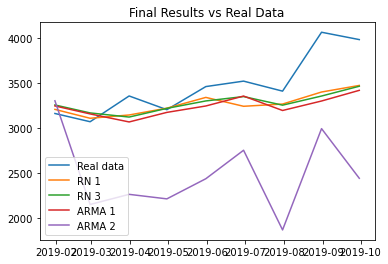

In [593]:
plt.plot(FINAL_RESULTS['Real'], label = 'Real data')
plt.plot(FINAL_RESULTS['N1'], label = 'RN 1')
plt.plot(FINAL_RESULTS['N3'], label = 'RN 3')
plt.plot(FINAL_RESULTS['Fcst1'], label = 'ARMA 1')
plt.plot(FINAL_RESULTS['Fcst2'], label = 'ARMA 2')
plt.legend()
plt.title('Final Results vs Real Data')
plt.show()

In [565]:
#Diebold - Mariano 

def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    
  
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt


pred1_lst= Final_RN['N1']
pred2_lst= Final_RN['N3']
actual_lst=Summary['Real']




rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="MAD")
print (rt)
rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="MSE")
print (rt)
rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="poly", power=2)
print (rt)



dm_return(DM=-0.8398569684706876, p_value=0.42537418949777417)
dm_return(DM=-0.7389973813140608, p_value=0.4810259310772369)
dm_return(DM=-0.7389973813140608, p_value=0.4810259310772369)


In [588]:
print('El RMSE para RN 1 es:',((FINAL_RESULTS['Real'] - FINAL_RESULTS['N1']) ** 2).mean() ** .5)
print('El RMSE para RN 3 es:',((FINAL_RESULTS['Real']  - FINAL_RESULTS['N3']) ** 2).mean() ** .5)
print('El RMSE para ARMA1 es:',((FINAL_RESULTS['Real'] - FINAL_RESULTS['Fcst1']) ** 2).mean() ** .5)
print('El RMSE para ARMA2 es:',((FINAL_RESULTS['Real'] - FINAL_RESULTS['Fcst2']) ** 2).mean() ** .5)

El RMSE para RN 1 es: 309.06353741198745
El RMSE para RN 3 es: 319.8829438948482
El RMSE para ARMA1 es: 352.3671695044131
El RMSE para ARMA2 es: 1082.597055592388
